OBLIGATORIO MACHINE LEARNING
Agustina Disiot 221025
Ivan Monjardin 239850

Primero vamos a importar todo lo que vamos a usar

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation,LeakyReLU, Dropout
from tensorflow.keras import activations
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

Cargamos el data set

In [ ]:
df=pd.read_csv("new_classification_train.csv", sep = ",")

In [121]:
df.head()

id                                           headline  \
0   0  Does Romans 13 Give The President The Right To...   
1   1          How To Throw A Marijuana-Friendly Wedding   
2   2  The New Yorker Finally Realized Us Plebeians D...   
3   3             The 10 Best U.S. Cities For Retirement   
4   4  Justin Bieber Punches Man In The Face, Leaves ...   

                                             authors  \
0  David J. Dunn, PhD, ContributorTheological tro...   
1                                                NaN   
2                                      Katla McGlynn   
3  PureWow, ContributorWhat your girl crush reads...   
4                                    Carly Ledbetter   

                                   short_description        date  \
0  Let any who doubt the lamentable state of theo...  2017-08-12   
1  Designate a pot-smoking area. While brides and...  2014-04-09   
2                                                NaN  2014-10-23   
3  Next question: When is too early to start coun...  2017-07-10   
4            This fan got WAY too close for comfort.  2016-11-23   

        category  
0       RELIGION  
1       WEDDINGS  
2         COMEDY  
3       BUSINESS  
4  ENTERTAINMENT

El head lo hicimos para ver que headlines habia y ver la estructura de cada una de las variables.

Hacemos el pandas profiling para obtener una analisis mas detallado de los datos.

In [122]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df)

profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134571 entries, 0 to 134570
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 134571 non-null  int64 
 1   headline           134568 non-null  object
 2   authors            110094 non-null  object
 3   short_description  121308 non-null  object
 4   date               134571 non-null  object
 5   category           134571 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.2+ MB


Hicimos el pandas profiling. Vimos que faltaban columnas. Analizamos el tipo de los datos y vemos que son de tipo object. Ahora vamos a cambiar ese tipo para que aparezcan en el pandas profiling.

In [124]:
df['headline'] = (df['headline']).astype(str)

Probamos cambiar un tipo y luego cambiamos todos.

In [125]:
df = df.astype({
    "headline" : "str",
    "authors" : "str",
    "short_description" : "str",
    "date" : "str",
    "category" : "str",
})

Hicimos de nuevo el pandas profiling para los nuevos tipos de datos.

In [126]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df)

profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Pero vimos que no era conveniente porque los que antes eran missing values ahora cuentan como valores "nan" que no nos sirven y preferimos dejarlos como que no estan. 

In [4]:
df=pd.read_csv("new_classification_train.csv", sep = ",")

Vamos a hacer un histograma de la fecha para ver si los articulos esan uniformamente distribuidos o si hay alguna fecha donde hay mas o menos articulos.

<AxesSubplot:>

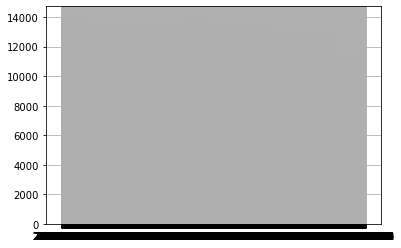

In [128]:
df['date'].hist()

Con la fecha de tipo 'object' no salio bien y vamos a convertirlo a otro tipo.

Primero convertimos la fecha a formato string y luego a numerico, quitandole los guiones, para poder hacer un histograma

In [5]:
df['date'] = (df['date']).astype(str)

In [6]:
df['date'] = pd.to_numeric(df['date'].str.replace('-',''))

In [131]:
df.head()

id                                           headline  \
0   0  Does Romans 13 Give The President The Right To...   
1   1          How To Throw A Marijuana-Friendly Wedding   
2   2  The New Yorker Finally Realized Us Plebeians D...   
3   3             The 10 Best U.S. Cities For Retirement   
4   4  Justin Bieber Punches Man In The Face, Leaves ...   

                                             authors  \
0  David J. Dunn, PhD, ContributorTheological tro...   
1                                                NaN   
2                                      Katla McGlynn   
3  PureWow, ContributorWhat your girl crush reads...   
4                                    Carly Ledbetter   

                                   short_description      date       category  
0  Let any who doubt the lamentable state of theo...  20170812       RELIGION  
1  Designate a pot-smoking area. While brides and...  20140409       WEDDINGS  
2                                                NaN  20141023         COMEDY  
3  Next question: When is too early to start coun...  20170710       BUSINESS  
4            This fan got WAY too close for comfort.  20161123  ENTERTAINMENT

<AxesSubplot:>

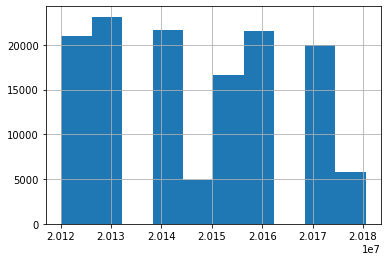

In [132]:
df['date'].hist()

Nos dimos cuenta que para el tipo numerico van a quedar algunos espacios porque no hay fechas entre los meses 13-99.

Intentamos hacerlo por año, para el año 2016 y ocurre lo mismo, no hay fechas para los dias 32-99. Sin embargo si ponemos bins=12, queda mejor agrupado, ya que los dias que no existen no afectan tanto. Probablemente quede mejor graficado en una grafica de barras, pero ahi es mas complicado definir los meses.

<AxesSubplot:>

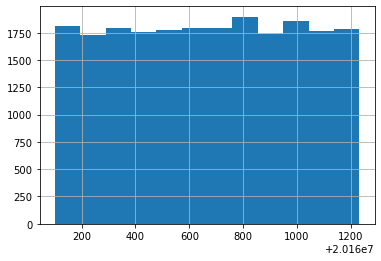

In [133]:
(df['date'][df['date'].apply(lambda x: str(x).startswith("2016"))]).hist(bins= 12)

Queremos utilizar la fecha para otros analisis, por ejemplo la cantidad de articulos por categoria a lo largo del tiempo. 
Obtenemos todas las categorias que hay, pero decidimos utitlizar el top 5 y luego agrupar todas las demas en 'other'

In [165]:
categories = pd.unique(df['category'])
categories

array(['RELIGION', 'WEDDINGS', 'COMEDY', 'BUSINESS', 'ENTERTAINMENT',
       'DIVORCE', 'QUEER VOICES', 'TRAVEL', 'CULTURE & ARTS', 'WORLDPOST',
       'IMPACT', 'BLACK VOICES', 'WELLNESS', 'HEALTHY LIVING',
       'WORLD NEWS', 'WOMEN', 'PARENTING', 'PARENTS', 'SCIENCE',
       'ENVIRONMENT', 'POLITICS', 'FOOD & DRINK', 'COLLEGE', 'CRIME',
       'TASTE', 'ARTS & CULTURE', 'GOOD NEWS', 'STYLE', 'WEIRD NEWS',
       'STYLE & BEAUTY', 'GREEN', 'HOME & LIVING', 'TECH', 'MEDIA',
       'THE WORLDPOST', 'SPORTS', 'ARTS', 'MONEY', 'LATINO VOICES',
       'FIFTY', 'EDUCATION'], dtype=object)

In [135]:
categories = ["POLITICS", "WELLNESS", "ENTERTAINMENT", "TRAVEL", "STYLE AND BEAUTY"]

Graficamos la cantidad de articulos en funcion del año por categoria.

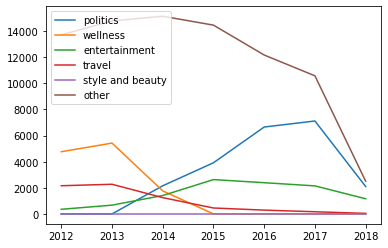

In [136]:
fig,ax=plt.subplots()
dates = ["2012", "2013", "2014", "2015", "2016", "2017", "2018"]
for category in categories:

    dateCat = df[['date','category']].sort_values('date')
    dateCat['date'] = dateCat['date'].apply(lambda x: str(x)[:4])
    dateCat['category'] = df['category'].apply(lambda x: 1 if (x==category) else 0 ) 
 
    cat = dateCat.groupby('date').sum()
    ax.plot(dates, cat, label = category.lower())

dateCat = df[['date','category']].sort_values('date')
dateCat['date'] = dateCat['date'].apply(lambda x: str(x)[:4])
dateCat['category'] = df['category'].apply(lambda x: 1 if (x not in categories) else 0 ) 
cat = dateCat.groupby('date').sum()

ax.plot(dates, cat, label = "other")


plt.legend(loc="upper left")
plt.show()

Ademas de graficar los valores abolutos, queriamos ver los relativos (porcentaje de esa categoria en el año). Para eso dividimos entre la cantidad anual.

In [137]:
dateCat2 = df[['date','category']].sort_values('date')
dateCat2['date'] = dateCat2['date'].apply(lambda x: str(x)[:4])
quantity = dateCat2.groupby('date').count()['category']
quantity

date
2012    20979
2013    23139
2014    21704
2015    21449
2016    21497
2017    19998
2018     5805
Name: category, dtype: int64

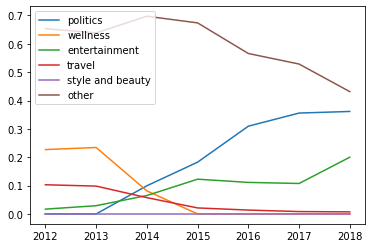

In [138]:
fig,ax=plt.subplots()
dates = ["2012", "2013", "2014", "2015", "2016", "2017", "2018"]
for category in categories:

    dateCat = df[['date','category']].sort_values('date')
    dateCat['date'] = dateCat['date'].apply(lambda x: str(x)[:4])
    dateCat['category'] = df['category'].apply(lambda x: 1 if (x==category) else 0 ) 
 
    cat = dateCat.groupby('date').sum()
    cat['category'] = cat['category'].div(quantity)
    ax.plot(dates, cat, label = category.lower())

dateCat = df[['date','category']].sort_values('date')
dateCat['date'] = dateCat['date'].apply(lambda x: str(x)[:4])
dateCat['category'] = df['category'].apply(lambda x: 1 if (x not in categories) else 0 ) 
cat = dateCat.groupby('date').sum()
cat['category'] = cat['category'].div(quantity)

ax.plot(dates, cat, label = "other")


plt.legend(loc="upper left")
plt.show()


Con el tipo datetime nos soluciona el problema de las fechas faltantes.

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

Ahora podemos hacer un histograma mejor y ver que en el ultimo año se seleccionaron menos articulos. 

<AxesSubplot:xlabel='date'>

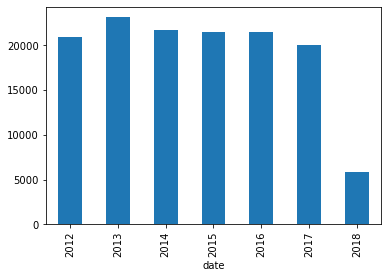

In [140]:
df['date'].groupby(df["date"].dt.year).count().plot(kind="bar")

<AxesSubplot:xlabel='date'>

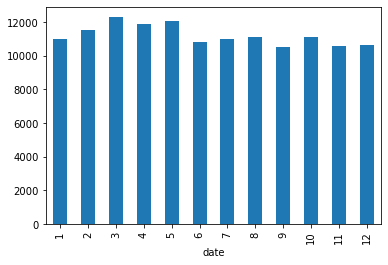

In [141]:
df['date'].groupby(df["date"].dt.month).count().plot(kind="bar")

<AxesSubplot:>

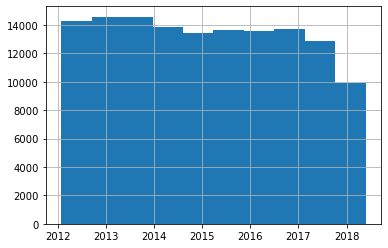

In [142]:
df['date'].hist()

In [143]:
df['date'].sort_values()

67882    2012-01-28
128367   2012-01-28
88093    2012-01-28
125747   2012-01-28
72390    2012-01-28
            ...    
44133    2018-05-26
112967   2018-05-26
114748   2018-05-26
24013    2018-05-26
68555    2018-05-26
Name: date, Length: 134571, dtype: datetime64[ns]

Otro analisis que queremos hacer es ver la relacion entre autores y categorias, si un autor tiende a escribir mas sobre una categoria o si esta distribuido.
Nuestra hipotesis es que sabiendo el autor es probable que puedas predecir la categoria de sus articulos.

El primer paso es pasar las variables de autores y categoria a variables categoricas

In [8]:
df['category'] = (df['category']).astype('category')

In [9]:
(df['authors']).astype('category')


0         David J. Dunn, PhD, ContributorTheological tro...
1                                                       NaN
2                                             Katla McGlynn
3         PureWow, ContributorWhat your girl crush reads...
4                                           Carly Ledbetter
                                ...                        
134566                                                  NaN
134567                W Magazine, Contributor\r\nW Magazine
134568    John Willey, Contributor\r\nBlogger, DaddysInC...
134569                                                  NaN
134570                           Damon Dahlen and Lee Moran
Name: authors, Length: 134571, dtype: category
Categories (22005, object): [' Basil Kreimendahl, Contributor\r\nPlaywright', ' Bill Bigelow, ContributorRethinking Schools ..., ' Bustle, Contributor\r\nNews, entertainment, ..., ' Bustle, ContributorNews, entertainment, life..., ..., 'yd Zeigler, Outsports', 'Élisabeth Badinter, Contributor

Nos dimos cuenta que la columna de los autores no es simplemente un nombre si no que tiene cierta descripcion, y en lugar de editar la columna en nuestro df agregamos la columna aparte. Agregamos una columna numerica para los autores para poder visualizar la relacion en el pandas profiling. 

In [146]:
df['category_nums'] = (df['category']).astype('category').cat.codes

In [147]:
df['authors_cat'] = (df['authors']).astype('category').cat.codes

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134571 entries, 0 to 134570
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 134571 non-null  int64         
 1   headline           134568 non-null  object        
 2   authors            110094 non-null  object        
 3   short_description  121308 non-null  object        
 4   date               134571 non-null  datetime64[ns]
 5   category           134571 non-null  category      
 6   category_nums      134571 non-null  int8          
 7   authors_cat        134571 non-null  int16         
dtypes: category(1), datetime64[ns](1), int16(1), int64(1), int8(1), object(3)
memory usage: 5.6+ MB


In [149]:
profile = ProfileReport(df)

profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


En el profiling nos dimos cuenta que tampoco nos ayudaba mucho y no se mostraban las correlaciones numericas.
Decidimos usar el seaborn para que nos muestre los numeros del indice de correlacion.

Text(0.5, 1.0, 'Correlation Heatmap')

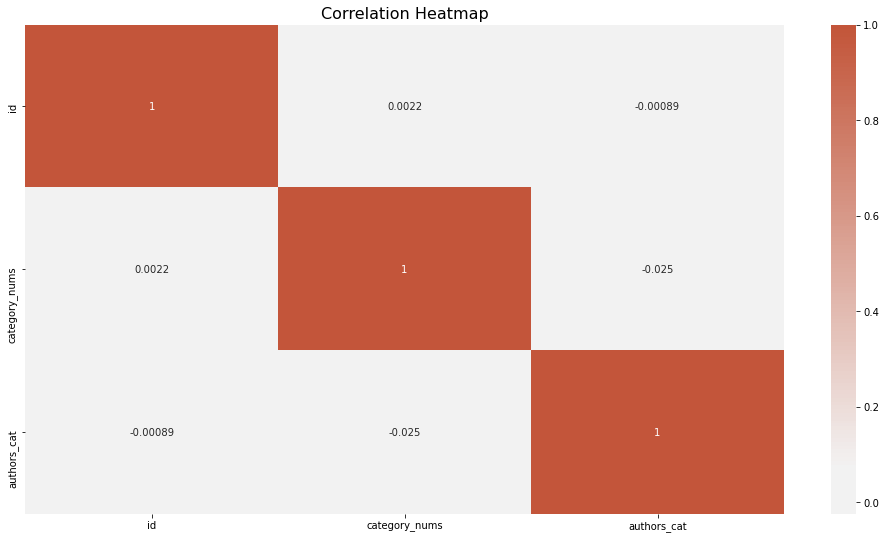

In [150]:
# Mapa de correlación (con detalle)
import seaborn as sns
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
plt.figure(figsize=(17,9))
sns.heatmap(df.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=16)

Tampoco nos servia mucho ver estos indices asi que hicimos el siguiente codigo para ver el numero de cuantas categorias diferentes que escribe cada autor.

In [151]:
difauthors = df['authors'].unique()
authorscat = []

In [152]:
for author in difauthors:
    print(len(df['category'][df['authors'] == author].unique()) , author)
    authorscat.append(len(df['category'][df['authors'] == author].unique()))

1 David J. Dunn, PhD, ContributorTheological troublemaker. Orthodox Christian.
0 nan
2 Katla McGlynn
5 PureWow, ContributorWhat your girl crush reads online
14 Carly Ledbetter
3 E. Oliver Whitney
1 Debbi Dickinson, Contributor
Entrepreneur
1 S. Bear Bergman, Contributorwriter, educator, publisher, storyteller, advice guy.
1 MiniTime, Contributor
MiniTime is the first family travel site with personalized rec...
4 Priscilla Frank
1 Raghida Dergham, ContributorColumnist and Senior Diplomatic Correspondent, Al Hayat
1 Renata M. Black, ContributorFounder, Empowered By You
1 Rep. Andre Carson, Contributor
Representative, Indiana’s 7th congressional district
20 Reuters, Reuters
5 Cole Delbyck
1 Cheryl Platzman Weinstock, Reuters
2 David Moye and Chris McGonigal
2 Jenny G. Perry, ContributorLife Coach and Author, 'Sexpot With Stretch Marks' and 'The Je...
3 Oyster.com, Contributor
The Hotel Tell-All
1 Heidi Mulligan Walker, Contributor
Founding Team, GapJumpers
1 Rabbi Laura Geller, Contributo

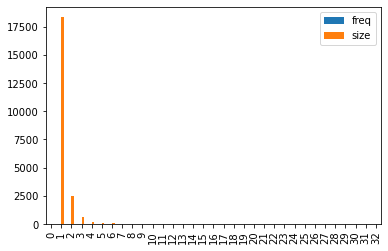

In [153]:
dfauth = pd.DataFrame({'freq': authorscat})
dfauth.groupby('freq', as_index=False).size().plot(kind='bar')
plt.show()

Para los articulos que tienen autor, la mayoria de los autores escriben en 1 categoria o maximo en 2 o 3. Claramente hay excepciones, como Reuters, que aparece en 20 categorias diferentes. Ademas creemos que esto puede estar sesgado por los autores que solo aparecen una vez, por o tanto queremos ahora analisar para los autores que aparecen mas veces. 

In [154]:
topauthors = df.groupby('authors').filter(lambda x: len(x) > 7)['authors'].unique()
print(topauthors)
print(len(topauthors))

['Katla McGlynn' 'PureWow, ContributorWhat your girl crush reads online'
 'Carly Ledbetter' ...
 'David Seaman, ContributorYouTuber, researcher, and cryptocurrency enthusiast'
 'Jacada Travel, Contributor\r\nInspired, Tailor-Made Travel to Latin America, Africa, Asia, A...'
 'Robin Korth, ContributorInternational author and speaker']
1603


In [155]:
topauthorscatc = []
for author in topauthors:
    print(len(df['category'][df['authors'] == author].unique()) , author)
    topauthorscatc.append(len(df['category'][df['authors'] == author].unique()))

2 Katla McGlynn
5 PureWow, ContributorWhat your girl crush reads online
14 Carly Ledbetter
3 E. Oliver Whitney
1 Debbi Dickinson, Contributor
Entrepreneur
1 MiniTime, Contributor
MiniTime is the first family travel site with personalized rec...
4 Priscilla Frank
1 Raghida Dergham, ContributorColumnist and Senior Diplomatic Correspondent, Al Hayat
20 Reuters, Reuters
5 Cole Delbyck
3 Oyster.com, Contributor
The Hotel Tell-All
1 James Michael Nichols
7 Caroline Bologna
9 Catherine Pearson
2 Jacqueline Howard
1 Kim Simon, Contributor
Writer. Mother. Wife. Truth-teller. Victim Advocate.
1 JJ Virgin, Contributor
Celebrity nutrition, fitness, and mindset expert
1 Food52, Contributor
food52.com
1 Karen Schaler, Contributor
Emmy award-winning screenwriter, producer, author and creator ...
12 Paige Lavender
2 Chris Weigant, ContributorPolitical writer and blogger at ChrisWeigant.com
2 Lawrence Hurley, Reuters
6 Stateline, ContributorStateline provides daily reporting and analysis on trends in s

(array([692., 357., 177., 118.,  60.,  47.,   0.,  24.,  21.,  15.,  13.,
         11.,   9.,   0.,   6.,   5.,   3.,   1.,   4.,   2.,   0.,   6.,
          4.,   9.,   3.,   3.,   2.,   0.,   1.,   3.,   2.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.]),
 array([ 1.        ,  1.85365854,  2.70731707,  3.56097561,  4.41463415,
         5.26829268,  6.12195122,  6.97560976,  7.82926829,  8.68292683,
         9.53658537, 10.3902439 , 11.24390244, 12.09756098, 12.95121951,
        13.80487805, 14.65853659, 15.51219512, 16.36585366, 17.2195122 ,
        18.07317073, 18.92682927, 19.7804878 , 20.63414634, 21.48780488,
        22.34146341, 23.19512195, 24.04878049, 24.90243902, 25.75609756,
        26.6097561 , 27.46341463, 28.31707317, 29.17073171, 30.02439024,
        30.87804878, 31.73170732, 32.58536585, 33.43902439, 34.29268293,
        35.14634146, 36.        ]),
 <BarContainer object of 41 artists>)

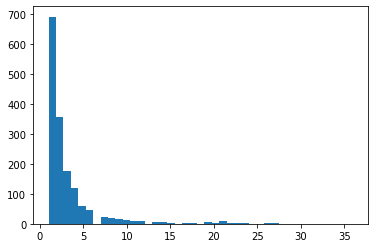

In [156]:
plt.hist(topauthorscatc, bins=41)

Si bien los autores que aparecen mas veces escriben sobre temas diferentes, en general la mayoria escriben siempre en una o dos categorias.

Analizamos los distintos atributos y sus NaN para ver si podimos reemplazarlos por algun otro valor (por ejemplo por la media o la moda). En principio no le vimos tanta utilidad y decidimos no hacerlo, si mas adelante vemos que podria sernos util para los distintos modelos, veremos.

Conclusiones del analisis: 
- Hay una cantidad (18%) de articulos sin autores especificados.
- Los articulos son desde el 2012 al 2018, aunque en el año 2018 solo llega hasta mayo (mes 5).
- La cantidad de articulos por año es similar, sin contar 2018.
- La distribucion de las categorias no es constante a lo largo del tiempo, por lo tanto la fecha va a ser una buena feature para estimar.
- Hay categorias que tienen poca cantidad de articulos, por lo tanto vamos a tener qe tenerlo en cuenta a la hora de elegir las metricas que utilicemos.
- El autor puede servir mucho para deducir la categoria.

Vamos a dejar en el dataframe solo las columnas que queremos, eliminando las que agregamos, que solo nos otorgan informacion repetida.


In [157]:
df.head()

id                                           headline  \
0   0  Does Romans 13 Give The President The Right To...   
1   1          How To Throw A Marijuana-Friendly Wedding   
2   2  The New Yorker Finally Realized Us Plebeians D...   
3   3             The 10 Best U.S. Cities For Retirement   
4   4  Justin Bieber Punches Man In The Face, Leaves ...   

                                             authors  \
0  David J. Dunn, PhD, ContributorTheological tro...   
1                                                NaN   
2                                      Katla McGlynn   
3  PureWow, ContributorWhat your girl crush reads...   
4                                    Carly Ledbetter   

                                   short_description       date  \
0  Let any who doubt the lamentable state of theo... 2017-08-12   
1  Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                NaN 2014-10-23   
3  Next question: When is too early to start coun... 2017-07-10   
4            This fan got WAY too close for comfort. 2016-11-23   

        category  category_nums  authors_cat  
0       RELIGION             26         5005  
1       WEDDINGS             35           -1  
2         COMEDY              5        11506  
3       BUSINESS              3        16913  
4  ENTERTAINMENT             10         3197

In [11]:
df = df.drop(columns=['authors_cat', 'category_nums', 'id'])

In [12]:
df

headline  \
0       Does Romans 13 Give The President The Right To...   
1               How To Throw A Marijuana-Friendly Wedding   
2       The New Yorker Finally Realized Us Plebeians D...   
3                  The 10 Best U.S. Cities For Retirement   
4       Justin Bieber Punches Man In The Face, Leaves ...   
...                                                   ...   
134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567                           Must-Try Bohemian Trends   
134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567              W Magazine, Contributor\r\nW Magazine   
134568  John Willey, Contributor\r\nBlogger, DaddysInC...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description       date  \
0       Let any who doubt the lamentable state of theo... 2017-08-12   
1       Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                     NaN 2014-10-23   
3       Next question: When is too early to start coun... 2017-07-10   
4                 This fan got WAY too close for comfort. 2016-11-23   
...                                                   ...        ...   
134566  A recent study of added sugar consumption in k... 2013-05-01   
134567  Whether it was the suede dresses at Calvin Kle... 2013-11-27   
134568  What is this world coming to that people would... 2012-02-02   
134569  The town was first established in 1913, when t... 2012-07-17   
134570                       A Donald Trump cape, anyone? 2016-07-22   

              category  
0             RELIGION  
1             WEDDINGS  
2               COMEDY  
3             BUSINESS  
4        ENTERTAINMENT  
...                ...  
134566        WELLNESS  
134567  STYLE & BEAUTY  
134568       PARENTING  
134569          TRAVEL  
134570           STYLE  

[134571 rows x 5 columns]

In [123]:
# Para rearmar todo el df con las modificaciones ejecutar este codigo,asi no tienen que ejecutar todo el codigo anterior y hacer las grafias de nuevo:
# Hacer los imports del comienzo antes
df=pd.read_csv("new_classification_train.csv", sep = ",")
df['date'] = (df['date']).astype(str)
df['date'] = pd.to_numeric(df['date'].str.replace('-',''))
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['category'] = (df['category']).astype('category')
df['authors'] = (df['authors']).astype('category')
df = df.drop(columns=['id'])

## Baseline

In [124]:
#TODO eliminar
copiaSeguridad = df.copy(deep=True)

Vamos a elegir las columnas headline y short_description. Despues veremos si vale la pena hacer el mismo analisis para authors.

Para hacer el count vectorize vamos a cambiar los Nan de headline y short_description a un string vacio. Esto no deberia afectar el resultado ya que los resultados del vectorizer no afectaran si no encuentra ninguna palabra en la descripcion.

In [125]:
df['headline'] = df['headline'].fillna('')

In [66]:
df

headline  \
0       Does Romans 13 Give The President The Right To...   
1               How To Throw A Marijuana-Friendly Wedding   
2       The New Yorker Finally Realized Us Plebeians D...   
3                  The 10 Best U.S. Cities For Retirement   
4       Justin Bieber Punches Man In The Face, Leaves ...   
...                                                   ...   
134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567                           Must-Try Bohemian Trends   
134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567              W Magazine, Contributor\r\nW Magazine   
134568  John Willey, Contributor\r\nBlogger, DaddysInC...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description       date  \
0       Let any who doubt the lamentable state of theo... 2017-08-12   
1       Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                     NaN 2014-10-23   
3       Next question: When is too early to start coun... 2017-07-10   
4                 This fan got WAY too close for comfort. 2016-11-23   
...                                                   ...        ...   
134566  A recent study of added sugar consumption in k... 2013-05-01   
134567  Whether it was the suede dresses at Calvin Kle... 2013-11-27   
134568  What is this world coming to that people would... 2012-02-02   
134569  The town was first established in 1913, when t... 2012-07-17   
134570                       A Donald Trump cape, anyone? 2016-07-22   

              category  
0             RELIGION  
1             WEDDINGS  
2               COMEDY  
3             BUSINESS  
4        ENTERTAINMENT  
...                ...  
134566        WELLNESS  
134567  STYLE & BEAUTY  
134568       PARENTING  
134569          TRAVEL  
134570           STYLE  

[134571 rows x 5 columns]

In [126]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['headline']
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

print(len(vectorizer.get_feature_names()))

47264


Al principio tenemos 47264 palabras diferentes en las headlines

Quitaremos las stop words y quedamos con 46976

Al utilizar el Stemmer en los parametros no se toma en cuenta el stop_words entonces lo quitamos

In [127]:
corpus = df['headline']
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language = 'english')
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(max_features=4000, max_df=0.9, min_df= 50, analyzer = stemmed_words)
vectorizer.fit(corpus)

print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['000', '10', '100', '101', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '35', '40', '4th', '50', '500', '60', '70', '90', '90s', 'aaron', 'abandon', 'abc', 'abl', 'abort', 'about', 'abroad', 'absolut', 'absurd', 'abus', 'academi', 'accept', 'access', 'accessori', 'accid', 'accident', 'accord', 'account', 'accus', 'achiev', 'aclu', 'across', 'act', 'action', 'activ', 'activist', 'actor', 'actress', 'actual', 'ad', 'adam', 'add', 'addict', 'address', 'adel', 'adhd', 'administr', 'admit', 'adopt', 'ador', 'adult', 'advanc', 'adventur', 'advertis', 'advic', 'advis', 'advoc', 'affair', 'affect', 'affleck', 'afford', 'afghan', 'afghanistan', 'afraid', 'africa', 'african', 'after', 'again', 'against', 'age', 'agenc', 'agenda', 'agent', 'ago', 'agre', 'agreement', 'ahead', 'aid', 'aim', 'air', 'airlin', 'airplan', 'airport', 'airstrik', 'al', 'alabama

In [128]:
headlineVecTrain = vectorizer.transform(corpus)
print(headlineVecTrain.toarray()) 
headlineMatrix = headlineVecTrain.toarray()
headlineMatrix_countVectorizer = headlineMatrix # nos va a servir para más adelante

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [129]:
print(headlineVecTrain)

  (0, 6)	1
  (0, 842)	1
  (0, 1200)	1
  (0, 1600)	1
  (0, 1953)	1
  (0, 2177)	1
  (0, 2368)	1
  (0, 2792)	2
  (0, 2832)	1
  (1, 1150)	1
  (1, 1385)	1
  (1, 1751)	1
  (1, 2818)	1
  (1, 2832)	1
  (1, 3017)	1
  (2, 850)	1
  (2, 1079)	1
  (2, 1191)	1
  (2, 1931)	1
  (2, 2276)	1
  (2, 2792)	1
  (2, 2794)	1
  (2, 2938)	1
  (2, 3098)	1
  (3, 1)	1
  :	:
  (134568, 278)	1
  (134568, 373)	1
  (134568, 388)	1
  (134568, 715)	1
  (134568, 1152)	1
  (134568, 1802)	1
  (134568, 1896)	1
  (134568, 2718)	1
  (134568, 3042)	1
  (134568, 3048)	1
  (134569, 98)	1
  (134569, 320)	1
  (134569, 380)	1
  (134569, 428)	1
  (134569, 2786)	2
  (134570, 135)	1
  (134570, 213)	2
  (134570, 221)	1
  (134570, 1037)	1
  (134570, 2029)	1
  (134570, 2378)	1
  (134570, 2615)	1
  (134570, 2792)	4
  (134570, 2847)	1
  (134570, 3002)	1


Ahora que tenemos las headlines vectorizados, vamos a crear un dataset para entrenarlo y crea un baseline.

In [130]:
dfmodel = df.copy(deep=True)
dfmodel = dfmodel.drop(columns=['short_description', 'headline', 'authors'])

In [10]:
dfmodel


date        category
0      2017-08-12        RELIGION
1      2014-04-09        WEDDINGS
2      2014-10-23          COMEDY
3      2017-07-10        BUSINESS
4      2016-11-23   ENTERTAINMENT
...           ...             ...
134566 2013-05-01        WELLNESS
134567 2013-11-27  STYLE & BEAUTY
134568 2012-02-02       PARENTING
134569 2012-07-17          TRAVEL
134570 2016-07-22           STYLE

[134571 rows x 2 columns]

In [131]:
pd.DataFrame(headlineMatrix)


0     1     2     3     4     5     6     7     8     9     ...  3104  \
0          0     0     0     0     0     0     1     0     0     0  ...     0   
1          0     0     0     0     0     0     0     0     0     0  ...     0   
2          0     0     0     0     0     0     0     0     0     0  ...     0   
3          0     1     0     0     0     0     0     0     0     0  ...     0   
4          0     0     0     0     0     0     0     0     0     0  ...     0   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
134566     0     0     0     0     0     0     1     0     0     0  ...     0   
134567     0     0     0     0     0     0     0     0     0     0  ...     0   
134568     0     0     0     0     0     0     0     0     0     0  ...     0   
134569     0     0     0     0     0     0     0     0     0     0  ...     0   
134570     0     0     0     0     0     0     0     0     0     0  ...     0   

        3105  3106  3107  3108  3109  3110  3111  3112  3113  
0          0     0     0     0     0     0     0     0     0  
1          0     0     0     0     0     0     0     0     0  
2          0     0     0     0     0     0     0     0     0  
3          0     0     0     0     0     0     0     0     0  
4          0     0     0     0     0     0     0     0     0  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
134566     0     0     0     0     0     0     0     0     0  
134567     0     0     0     0     0     0     0     0     0  
134568     0     0     0     0     0     0     0     0     0  
134569     0     0     0     0     0     0     0     0     0  
134570     0     0     0     0     0     0     0     0     0  

[134571 rows x 3114 columns]

In [12]:
dfmodel = dfmodel.join(pd.DataFrame(headlineMatrix))


In [75]:
dfmodel

date        category  0  1  2  3  4  5  6  7  ...  3104  3105  \
0      2017-08-12        RELIGION  0  0  0  0  0  0  1  0  ...     0     0   
1      2014-04-09        WEDDINGS  0  0  0  0  0  0  0  0  ...     0     0   
2      2014-10-23          COMEDY  0  0  0  0  0  0  0  0  ...     0     0   
3      2017-07-10        BUSINESS  0  1  0  0  0  0  0  0  ...     0     0   
4      2016-11-23   ENTERTAINMENT  0  0  0  0  0  0  0  0  ...     0     0   
...           ...             ... .. .. .. .. .. .. .. ..  ...   ...   ...   
134566 2013-05-01        WELLNESS  0  0  0  0  0  0  1  0  ...     0     0   
134567 2013-11-27  STYLE & BEAUTY  0  0  0  0  0  0  0  0  ...     0     0   
134568 2012-02-02       PARENTING  0  0  0  0  0  0  0  0  ...     0     0   
134569 2012-07-17          TRAVEL  0  0  0  0  0  0  0  0  ...     0     0   
134570 2016-07-22           STYLE  0  0  0  0  0  0  0  0  ...     0     0   

        3106  3107  3108  3109  3110  3111  3112  3113  
0          0     0     0     0     0     0     0     0  
1          0     0     0     0     0     0     0     0  
2          0     0     0     0     0     0     0     0  
3          0     0     0     0     0     0     0     0  
4          0     0     0     0     0     0     0     0  
...      ...   ...   ...   ...   ...   ...   ...   ...  
134566     0     0     0     0     0     0     0     0  
134567     0     0     0     0     0     0     0     0  
134568     0     0     0     0     0     0     0     0  
134569     0     0     0     0     0     0     0     0  
134570     0     0     0     0     0     0     0     0  

[134571 rows x 3116 columns]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    dfmodel.drop('category', axis=1),
    dfmodel['category'],
    test_size=(1.0/3), random_state=42)

print(f'df shape = {dfmodel.shape}')
print(f'X_train shape = {X_train.shape}\n{X_train.head()}\n------------------------')
print(f'Y_train shape = {Y_train.shape}\n{Y_train.head()}\n------------------------')
print(f'X_test shape = {X_test.shape}\n{X_test.head()}\n------------------------')
print(f'Y_test shape = {Y_test.shape}\n{Y_test.head()}')

df shape = (134571, 3116)
X_train shape = (89714, 3115)
             date  0  1  2  3  4  5  6  7  8  ...  3104  3105  3106  3107  \
28023  2014-08-26  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
113093 2013-04-15  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
72033  2014-06-07  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
130854 2017-10-06  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
72557  2018-05-15  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

        3108  3109  3110  3111  3112  3113  
28023      0     0     0     0     0     0  
113093     0     0     0     0     0     0  
72033      0     0     0     0     0     0  
130854     0     0     0     0     0     0  
72557      0     0     0     0     0     0  

[5 rows x 3115 columns]
------------------------
Y_train shape = (89714,)
28023          POLITICS
113093          DIVORCE
72033             WOMEN
130854         POLITICS
72557     ENTERTAINMENT
Name: category, 

In [15]:
X_train = dfmodel.drop(columns=['category'])
Y_train = dfmodel['category']

In [15]:
from sklearn.tree import DecisionTreeClassifier


tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [16]:
X_train["date"] = X_train["date"].values.astype('int')

In [17]:
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

[Text(932.5271739130435, 1009.5428571428572, '2098 <= 0.5\nentropy = 4.736\nsamples = 89714\nvalue = [680, 597, 1985, 2657, 528, 2279, 1491, 460, 1552\n442, 7153, 570, 625, 2778, 638, 1183, 3016, 1855\n1553, 497, 1272, 766, 3898, 1781, 14638, 2806, 1178\n977, 2187, 1015, 4335, 936, 918, 1603, 4399, 1594\n1182, 7986, 1562, 974, 1168]\nclass = TASTE'),
 Text(529.9483695652174, 854.2285714285715, '2892 <= 0.5\nentropy = 4.713\nsamples = 84281\nvalue = [660, 578, 1910, 2639, 525, 2193, 1479, 322, 1488\n442, 7017, 458, 623, 2413, 621, 1156, 3005, 1199\n1542, 491, 1265, 752, 3768, 1732, 14595, 2778, 1167\n941, 2150, 999, 2213, 931, 906, 1589, 3619, 1391\n1167, 7899, 1549, 965, 1144]\nclass = TASTE'),
 Text(286.58152173913044, 698.9142857142858, '3016 <= 0.5\nentropy = 4.8\nsamples = 78593\nvalue = [660, 548, 1856, 2600, 520, 1759, 1470, 322, 1486\n434, 6688, 458, 619, 2413, 619, 1120, 2985, 1199\n1531, 443, 1051, 752, 3768, 1718, 10638, 2689, 1141\n937, 2115, 981, 2211, 924, 901, 1499, 3614,

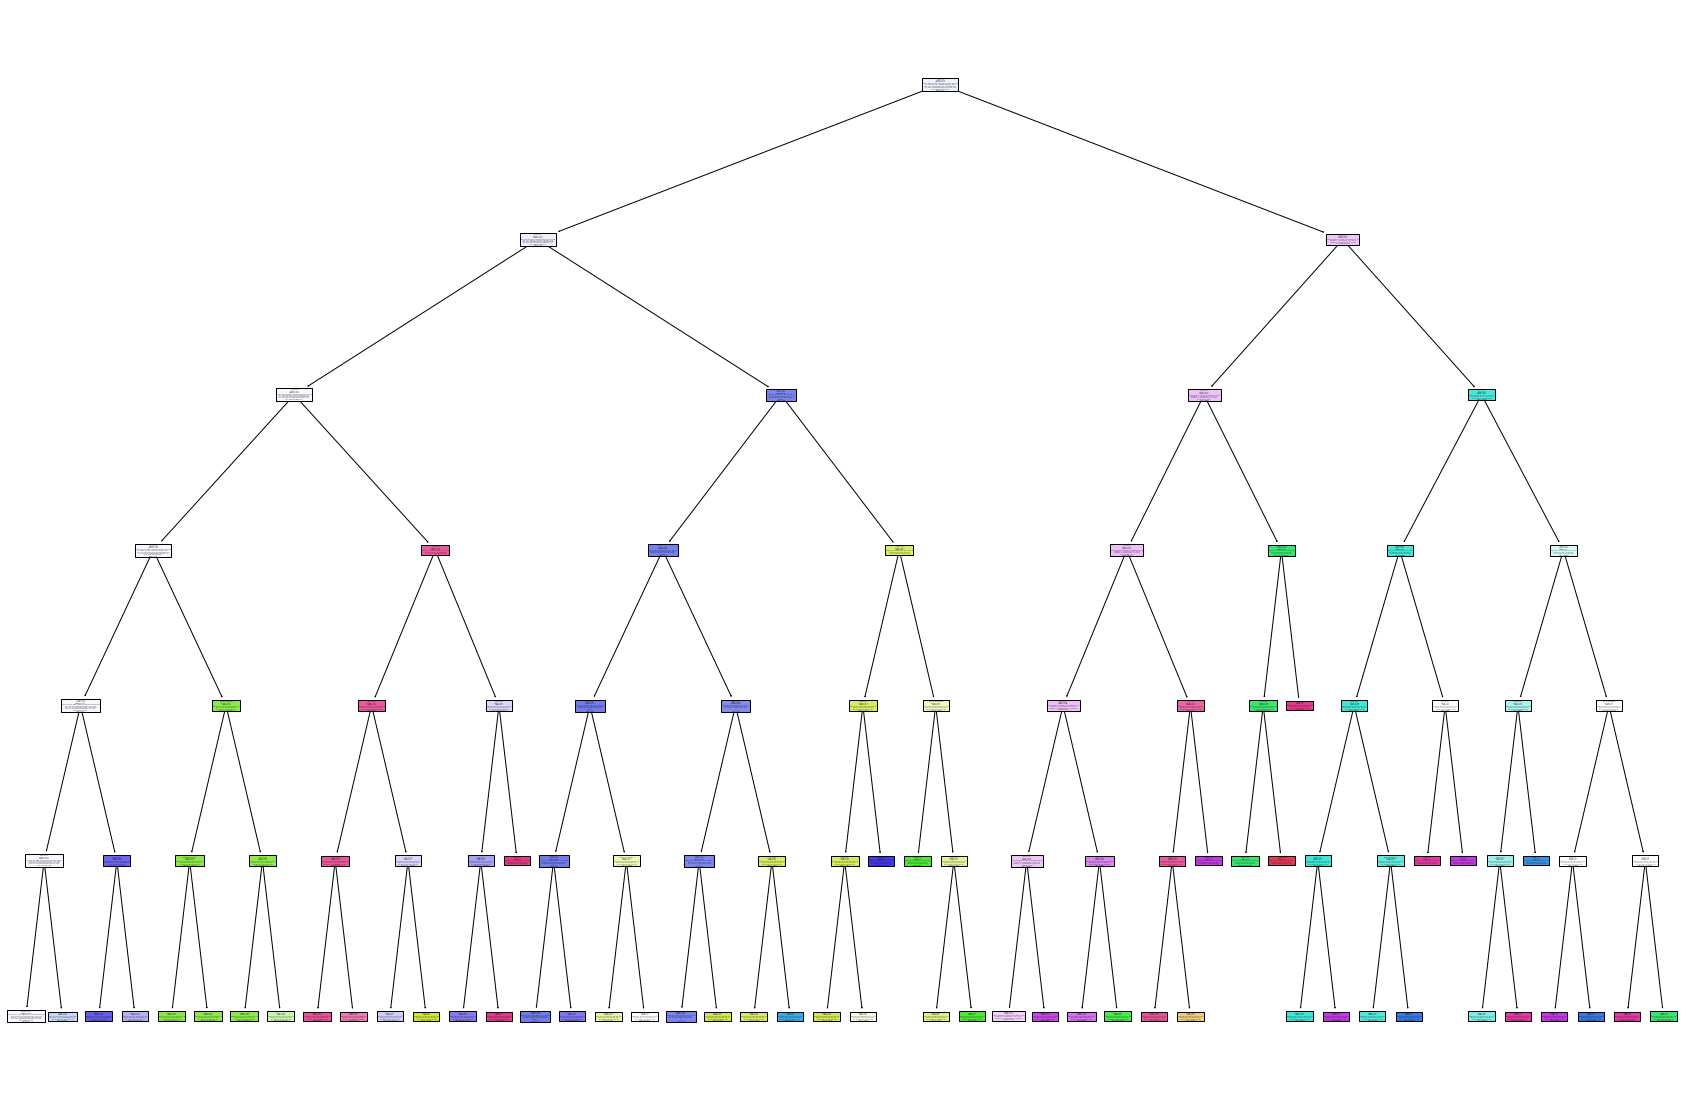

In [18]:
from sklearn import tree
fig = plt.figure(figsize=(30,20))
tree.plot_tree(tree_model, 
                   feature_names=dfmodel.columns,  
                   class_names=dfmodel['category'].unique(),
                   filled=True)

Aca podemos ver el árbol y vemos que los colores no son tan muy suaves como para que no le hayamos predecido a ninguna. 

In [19]:
X_test["date"] = X_test["date"].values.astype('int')

In [20]:
Y_pred = tree_model.predict(X_test)

In [21]:
X_test

date  0  1  2  3  4  5  6  7  8  ...  3104  3105  3106  3107  \
126111  1136525312  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
112548 -1633484800  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
85650  -1626472448  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
112842  -268566528  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
95590   -296615936  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...            ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
62826  -1843855360  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
109635   242089984  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
130730  -275578880  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
82708   1448280064  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
83884   1480785920  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

        3108  3109  3110  3111  3112  3113  
126111     0     0     0     0     0     0  
112548     0     0     0     0     0     0  
85650      0     0     0     0     0     0  
112842     0     0     0     0     0     0  
95590      0     0     0     0     0     0  
...      ...   ...   ...   ...   ...   ...  
62826      0     0     0     0     0     0  
109635     0     0     0     0     0     0  
130730     0     0     0     0     0     0  
82708      0     0     0     0     0     0  
83884      0     0     0     0     0     0  

[44857 rows x 3115 columns]

In [115]:
from sklearn.metrics import balanced_accuracy_score

In [22]:
print("Macro Average Recall:", balanced_accuracy_score(Y_test, Y_pred)*100, "%")

Macro Average Recall: 7.343899342243025 %


In [24]:
def calculate_accuracy(un_arbol, X_test, Y_test):
  from sklearn.metrics import accuracy_score
  Y_prediction = un_arbol.predict(X_test)
  return accuracy_score(Y_prediction, Y_test)

In [25]:
print("Accuracy:", calculate_accuracy(tree_model, X_test, Y_test)*100, "%")

Accuracy: 21.898477383685936 %


### Primera submision a kaggle

Ya tenemos nuestro primer modelo 

In [88]:
dftest=pd.read_csv("new_classification_test.csv", sep = ",")
dftest['date'] = (dftest['date']).astype(str)
dftest['date'] = pd.to_numeric(dftest['date'].str.replace('-',''))
dftest['date'] = pd.to_datetime(dftest['date'], format='%Y%m%d')
dftest['date'] = dftest['date'].values.astype("int")
dftest['headline'] = dftest['headline'].fillna('')
corpus = dftest['headline']
headlineVecTest= vectorizer.transform(corpus)
headlineMatrix = headlineVecTest.toarray()
dftest = dftest.drop(columns=['short_description', 'headline', 'authors', 'id'])
dftest = pd.concat([dftest, pd.DataFrame(headlineMatrix)], axis=1)
dftest

date  0  1  2  3  4  5  6  7  8  ...  3104  3105  3106  3107  \
0     -2078474240  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
1      -881852416  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
2       626524160  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
3      -911802368  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
4      1570045952  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...           ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
66277 -2019819520  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
66278  -820641792  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
66279   577437696  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
66280   996278272  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
66281  -649789440  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

       3108  3109  3110  3111  3112  3113  
0         0     0     0     0     0     0  
1         0     0     0     0     0     0  
2         0     0     0     0     0     0  
3         0     0     0     0     0     0  
4         0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...  
66277     0     0     0     0     0     0  
66278     0     0     0     0     0     0  
66279     0     0     0     0     0     0  
66280     0     0     0     0     0     0  
66281     0     0     0     0     0     0  

[66282 rows x 3115 columns]

In [89]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66282 entries, 0 to 66281
Columns: 3115 entries, date to 3113
dtypes: int32(1), int64(3114)
memory usage: 1.5 GB


In [90]:
Y_pred = tree_model.predict(dftest)

In [ ]:
Y_pred_cat = pd.DataFrame(Y_pred)
Y_pred_cat["category"] = categoryOHE.inverse_transform(Y_pred)
Y_pred_cat = Y_pred_cat["category"] 

Y_test_transformedBack = pd.DataFrame(Y_test)
Y_test_transformedBack["category"] = categoryOHE.inverse_transform(Y_test) 
Y_test_transformedBack = Y_test_transformedBack["category"] 

print("Macro Average Recall:", balanced_accuracy_score(Y_pred_cat, Y_test_transformedBack)*100, "%")

Macro Average Recall: 46.362743345317185 %


C:\Users\ivanm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [91]:
print(Y_pred)
print(len(Y_pred))

['POLITICS' 'POLITICS' 'DIVORCE' ... 'QUEER VOICES' 'POLITICS' 'POLITICS']
66282


In [93]:
pd.DataFrame(data=Y_pred).to_csv("primeraEntrega.csv")

Ya tenemos nuestra primera baseline de MAR: 7.3% tanto local como en Kaggle
Por ahora solo los atributos que consideramos fueron: la date (que convertimos a int y que no quedo del todo bien) y el headlines que separamos en palabras con vectorizer
Puntos de mejora:
- Cambiar la date a algo más entendible, por ejemplo utc o cantidad de dias de utc
- Aplicar un stop_words al vectorizer que no nos dejo por aplicar el stemmer
- Probar usar un lemmer en vez de un stemmer
- Agregar el short_description y el autor a las features para predecir
- Probar una bag of words distintas: 
  - Probablemente tengamos que disminuir la cantidad para soportar más features (sino no creo que nos aguante la computadora)
  - Elegir palabras para cada categoria (probar si sirve más)
  - Agregar Tfldf
  - Agregar más features
- Usar cross validation / dev set
- Usar todos el train set (no hacer la separacion), para trainear los parametros para el test de kaggle. Esto me daria más datos para entrenar y por lo tanto bajar el bias. 

Para las features que se tomaron en cuenta, y tomando en cuenta que esto es una baseline, el resultado es bastante bien. 

### Ingeniería de atributos

TODO

### Deep learning
Ahora vamos a probar crear una red neuronal y ver si su resultado es mejor

In [33]:
# El df que tenemos hasta ahora
dfmodel

date        category  0  1  2  3  4  5  6  7  ...  3104  3105  \
0       -999161856        RELIGION  0  0  0  0  0  0  1  0  ...     0     0   
1      -1230569472        WEDDINGS  0  0  0  0  0  0  0  0  ...     0     0   
2      -2005794816          COMEDY  0  0  0  0  0  0  0  0  ...     0     0   
3        155385856        BUSINESS  0  1  0  0  0  0  0  0  ...     0     0   
4        228065280   ENTERTAINMENT  0  0  0  0  0  0  0  0  ...     0     0   
...            ...             ... .. .. .. .. .. .. .. ..  ...   ...   ...   
134566    97386496        WELLNESS  0  0  0  0  0  0  1  0  ...     0     0   
134567   949747712  STYLE & BEAUTY  0  0  0  0  0  0  0  0  ...     0     0   
134568  1404305408       PARENTING  0  0  0  0  0  0  0  0  ...     0     0   
134569 -1930559488          TRAVEL  0  0  0  0  0  0  0  0  ...     0     0   
134570 -1420558336           STYLE  0  0  0  0  0  0  0  0  ...     0     0   

        3106  3107  3108  3109  3110  3111  3112  3113  
0          0     0     0     0     0     0     0     0  
1          0     0     0     0     0     0     0     0  
2          0     0     0     0     0     0     0     0  
3          0     0     0     0     0     0     0     0  
4          0     0     0     0     0     0     0     0  
...      ...   ...   ...   ...   ...   ...   ...   ...  
134566     0     0     0     0     0     0     0     0  
134567     0     0     0     0     0     0     0     0  
134568     0     0     0     0     0     0     0     0  
134569     0     0     0     0     0     0     0     0  
134570     0     0     0     0     0     0     0     0  

[134571 rows x 3116 columns]

In [34]:
#TODO eliminar
copiaSeguridad2 = dfmodel

In [129]:
#Agarrar responsaldo TODO eliminar
dmmodel = copiaSeguridad2

#### Definiciones iniciales para todas las redes neuronales

In [130]:
dfmodel["date"] = dfmodel["date"].values.astype('int')

In [131]:
x = dfmodel.drop('category', axis=1)

categoriesTransform = dfmodel['category'].to_numpy()
categoriesTransform.shape
categoriesTransform = categoriesTransform.reshape(-1,1)
categoriesTransform.shape
categoryOHE = OneHotEncoder(handle_unknown='ignore')
y = categoryOHE.fit_transform(categoriesTransform)
y = y.toarray()

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x,
    y,
    test_size=(1.0/3), random_state=42)

In [102]:
def make_NN_model(output_shapes, input_shape, use_bias, activations, dropouts, opt, loss, metric):
  model = Sequential()
  layers=len(output_shapes)
  for i in range(0, layers):
    if i == 0 : model.add(Dense(output_shapes[i], input_shape = (input_shape,), use_bias = use_bias))
    if i != 0 : model.add(Dense(output_shapes[i], use_bias = use_bias))
    model.add(Activation(activations[i]))
    if dropouts[i] != None : model.add(dropouts[i])
  model.compile(loss=loss, optimizer=opt, metrics=[metric])
  return model

Vamos a definir un earlyStopping, esto permite que el modelo no siga "bajando" mientras entrena. Esto evita el sobreajust, si no ponemos earlyStopping o la patience es muy alta, el modelo va a llegar a un punto donde baje el error y va a concentrarse ahi, hasta disminuir lo más posible el error de train o hasta que acaben las epochs. Esto tambien permite parar las epochs antes y consumir menos procesamiento si no es necesario

In [103]:
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=25)

#### Primera red neuronal
Es principalmente para reviar que funcione todo y tener un baseline de las redes neuronales para despues poder tomar decisiones a partir de los resultados iniciales
De vuelta, para este caso vamos a usar la date y el heading vectorizado

In [132]:
model = make_NN_model(output_shapes=[20, 30, Y_train.shape[1]],
                      input_shape=len(X_train.columns),
                      use_bias=True,
                      activations=[LeakyReLU(alpha=0.3), LeakyReLU(alpha=0.3), 'softmax'],
                      dropouts=[Dropout(0.3), None, None],
                      opt='Adam',
                      loss='categorical_crossentropy',
                      metric=["categorical_accuracy", "Recall", "accuracy"])

In [136]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 20)                62320     
_________________________________________________________________
activation_38 (Activation)   (None, 20)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 30)                630       
_________________________________________________________________
activation_39 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 41)                1271      
_________________________________________________________________
activation_40 (Activation)   (None, 41)              

In [137]:
training = model.fit(X_train, Y_train, epochs=500, batch_size=100, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
718/718 [==============================] - 6s 8ms/step - loss: 818115.3125 - categorical_accuracy: 0.0405 - recall: 0.0405 - accuracy: 0.0405 - val_loss: 40881.6445 - val_categorical_accuracy: 0.0879 - val_recall: 0.0879 - val_accuracy: 0.0879
Epoch 2/500
718/718 [==============================] - 3s 5ms/step - loss: 72177.8906 - categorical_accuracy: 0.0461 - recall: 0.0461 - accuracy: 0.0461 - val_loss: 52687.7969 - val_categorical_accuracy: 0.0929 - val_recall: 0.0929 - val_accuracy: 0.0929
Epoch 3/500
718/718 [==============================] - 3s 4ms/step - loss: 45184.1992 - categorical_accuracy: 0.0487 - recall: 0.0487 - accuracy: 0.0487 - val_loss: 24263.5586 - val_categorical_accuracy: 0.0363 - val_recall: 0.0363 - val_accuracy: 0.0363
Epoch 4/500
718/718 [==============================] - 3s 4ms/step - loss: 28441.8613 - categorical_accuracy: 0.0511 - recall: 0.0510 - accuracy: 0.0511 - val_loss: 15957.1123 - val_categorical_accuracy: 0.0261 - val_recall: 0.0261 - 

Una vez que entrenamos el modelo es hora de usarlo para predecir el Y

In [138]:
Y_pred = model.predict(X_test)


Vamos a revisar que el X_test haya quedado bien formateado 

In [139]:
X_test

date  0  1  2  3  4  5  6  7  8  ...  3104  3105  3106  3107  \
126111  1136525312  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
112548 -1633484800  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
85650  -1626472448  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
112842  -268566528  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
95590   -296615936  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...            ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
62826  -1843855360  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
109635   242089984  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
130730  -275578880  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
82708   1448280064  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
83884   1480785920  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

        3108  3109  3110  3111  3112  3113  
126111     0     0     0     0     0     0  
112548     0     0     0     0     0     0  
85650      0     0     0     0     0     0  
112842     0     0     0     0     0     0  
95590      0     0     0     0     0     0  
...      ...   ...   ...   ...   ...   ...  
62826      0     0     0     0     0     0  
109635     0     0     0     0     0     0  
130730     0     0     0     0     0     0  
82708      0     0     0     0     0     0  
83884      0     0     0     0     0     0  

[44857 rows x 3115 columns]

In [140]:
def uniqueCategoriesPredicted(Y_pred):
  temp = pd.DataFrame(Y_pred)
  temp["col"] = categoryOHE.inverse_transform(Y_pred)
  return temp["col"].unique()
  
uniqueCategoriesPredicted(Y_pred)

array(['POLITICS'], dtype=object)

#### Segunda red neuronal: Sin date

Despues de entrenar el primre modelo, nos dimos cuenta que siempre se predecia "POLITICS", el cual es la categoria más frecuento. Esto problamente se va por un problema de mucho variance o que la fecha (el atributo más diferente) este afectando

Primero voy a probar con sacarle la fecha y ver si mejora. De esta manera, si hay un problema me puedo asegurar que no es culpa de los atributos, sino del modelo en si o un problema de programación

In [141]:
X_trainNoDate = X_train.drop(columns=["date"])
X_testNoDate =X_test.drop(columns=["date"])

model = make_NN_model(output_shapes=[20, 30, Y_train.shape[1]],
                      input_shape=len(X_trainNoDate.columns),
                      use_bias=True,
                      activations=[LeakyReLU(alpha=0.3), LeakyReLU(alpha=0.3), 'softmax'],
                      dropouts=[Dropout(0.3), None, None],
                      opt='Adam',
                      loss='categorical_crossentropy',
                      metric=["categorical_accuracy", "Recall", "accuracy"])

training = model.fit(X_trainNoDate, Y_train, epochs=500, batch_size=100, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
718/718 [==============================] - 6s 9ms/step - loss: 2.8043 - categorical_accuracy: 0.2954 - recall: 0.1005 - accuracy: 0.2954 - val_loss: 2.2466 - val_categorical_accuracy: 0.4358 - val_recall: 0.1981 - val_accuracy: 0.4358
Epoch 2/500
718/718 [==============================] - 4s 5ms/step - loss: 2.1637 - categorical_accuracy: 0.4450 - recall: 0.2324 - accuracy: 0.4450 - val_loss: 2.0320 - val_categorical_accuracy: 0.4740 - val_recall: 0.2740 - val_accuracy: 0.4740
Epoch 3/500
718/718 [==============================] - 4s 5ms/step - loss: 1.9999 - categorical_accuracy: 0.4800 - recall: 0.2768 - accuracy: 0.4800 - val_loss: 1.9612 - val_categorical_accuracy: 0.4858 - val_recall: 0.3020 - val_accuracy: 0.4858
Epoch 4/500
718/718 [==============================] - 3s 5ms/step - loss: 1.9108 - categorical_accuracy: 0.4972 - recall: 0.2994 - accuracy: 0.4972 - val_loss: 1.9245 - val_categorical_accuracy: 0.4950 - val_recall: 0.3200 - val_accuracy: 0.4950
Epoch 5/500


In [142]:
Y_pred = model.predict(X_testNoDate)
uniqueCategoriesPredicted(Y_pred)

array(['COMEDY', 'TRAVEL', 'CRIME', 'POLITICS', 'WEDDINGS',
       'QUEER VOICES', 'BLACK VOICES', 'RELIGION', 'BUSINESS',
       'ENVIRONMENT', 'ENTERTAINMENT', 'FOOD & DRINK', 'WELLNESS',
       'PARENTING', 'GREEN', 'TECH', 'STYLE & BEAUTY', 'HOME & LIVING',
       'SCIENCE', 'SPORTS', 'DIVORCE', 'IMPACT', 'WOMEN', 'THE WORLDPOST',
       'HEALTHY LIVING', 'STYLE', 'WORLDPOST', 'EDUCATION', 'WEIRD NEWS',
       'MEDIA', 'LATINO VOICES', 'CULTURE & ARTS', 'COLLEGE', 'MONEY',
       'GOOD NEWS', 'PARENTS', 'ARTS', 'TASTE', 'ARTS & CULTURE'],
      dtype=object)

Ahora si, las predicciones parecen mejores, ahora no se predice siempre POLITICS. Ahora vamos calcular la MAR. Primero tenemos que pasar lo que se transoformo con One Hot Enconder a la category que estaba antes. 

In [156]:
Y_pred_cat = pd.DataFrame(Y_pred)
Y_pred_cat["category"] = categoryOHE.inverse_transform(Y_pred)
Y_pred_cat = Y_pred_cat["category"] 

Y_test_transformedBack = pd.DataFrame(Y_test)
Y_test_transformedBack["category"] = categoryOHE.inverse_transform(Y_test) 
Y_test_transformedBack = Y_test_transformedBack["category"] 

print("Macro Average Recall:", balanced_accuracy_score(Y_pred_cat, Y_test_transformedBack)*100, "%")

Macro Average Recall: 46.362743345317185 %


C:\Users\ivanm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [ ]:
for word in full_list:
  dftemp[word] = dftemp['headline'].str.count(word)
dftemp

headline  \
0       Does Romans 13 Give The President The Right To...   
1               How To Throw A Marijuana-Friendly Wedding   
2       The New Yorker Finally Realized Us Plebeians D...   
3                  The 10 Best U.S. Cities For Retirement   
4       Justin Bieber Punches Man In The Face, Leaves ...   
...                                                   ...   
134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567                           Must-Try Bohemian Trends   
134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567              W Magazine, Contributor\r\nW Magazine   
134568  John Willey, Contributor\r\nBlogger, DaddysInC...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description  date  \
0       Let any who doubt the lamentable state of theo...     0   
1       Designate a pot-smoking area. While brides and...     0   
2                                                     NaN     0   
3       Next question: When is too early to start coun...     0   
4                 This fan got WAY too close for comfort.     0   
...                                                   ...   ...   
134566  A recent study of added sugar consumption in k...     0   
134567  Whether it was the suede dresses at Calvin Kle...     0   
134568  What is this world coming to that people would...     0   
134569  The town was first established in 1913, when t...     0   
134570                       A Donald Trump cape, anyone?     0   

              category  's  abuse  america  american  archbishop  ...  learn  \
0             RELIGION   0      0        0         0           0  ...      0   
1             WEDDINGS   0      0        0         0           0  ...      0   
2               COMEDY   0      0        0         0           0  ...      0   
3             BUSINESS   0      0        0         0           0  ...      0   
4        ENTERTAINMENT   0      0        0         0           0  ...      0   
...                ...  ..    ...      ...       ...         ...  ...    ...   
134566        WELLNESS   0      0        0         0           0  ...      0   
134567  STYLE & BEAUTY   0      0        0         0           0  ...      0   
134568       PARENTING   0      0        0         0           0  ...      0   
134569          TRAVEL   0      0        0         0           0  ...      0   
134570           STYLE   0      0        0         0           0  ...      0   

        learning  reform  search  standard  start  teacher  teaching  tenure  \
0              0       0       0         0      0        0         0       0   
1              0       0       0         0      0        0         0       0   
2              0       0       0         0      0        0         0       0   
3              0       0       0         0      0        0         0       0   
4              0       0       0         0      0        0         0       0   
...          ...     ...     ...       ...    ...      ...       ...     ...   
134566         0       0       0         0      0        0         0       0   
134567         0       0       0         0      0        0         0       0   
134568         0       0       0         0      0        0         0       0   
134569         0 

Llegamos a un MAR de 46.3% en nuestros datos de test. Ahora hay que probarlos con los datos de Kaggle. 

In [158]:
dftest=pd.read_csv("new_classification_test.csv", sep = ",")
dftest['headline'] = dftest['headline'].fillna('')
corpus = dftest['headline']
headlineVecTest= vectorizer.transform(corpus)
headlineMatrix = headlineVecTest.toarray()
dftest = dftest.drop(columns=['short_description', 'headline', 'authors', 'id', 'date'])
dftest = pd.concat([dftest, pd.DataFrame(headlineMatrix)], axis=1)
dftest

0     1     2     3     4     5     6     7     8     9     ...  3104  \
0         0     0     0     0     0     0     0     0     0     0  ...     0   
1         0     0     0     0     0     0     0     0     0     0  ...     0   
2         0     0     0     0     0     0     0     0     0     0  ...     0   
3         0     0     0     0     0     0     0     0     0     0  ...     0   
4         0     0     0     0     0     0     0     0     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
66277     0     0     0     0     0     0     0     0     0     0  ...     0   
66278     0     0     0     0     0     0     0     0     0     0  ...     0   
66279     0     0     0     0     0     0     0     0     0     0  ...     0   
66280     0     0     0     0     0     0     0     0     0     0  ...     0   
66281     0     0     0     0     0     0     0     0     0     0  ...     0   

       3105  3106  3107  3108  3109  3110  3111  3112  3113  
0         0     0     0     0     0     0     0     0     0  
1         0     0     0     0     0     0     0     0     0  
2         0     0     0     0     0     0     0     0     0  
3         0     0     0     0     0     0     0     0     0  
4         0     0     0     0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
66277     0     0     0     0     0     0     0     0     0  
66278     0     0     0     0     0     0     0     0     0  
66279     0     0     0     0     0     0     0     0     0  
66280     0     0     0     0     0     0     0     0     0  
66281     0     0     0     0     0     0     0     0     0  

[66282 rows x 3114 columns]

In [159]:
Y_pred = model.predict(dftest)

In [ ]:
for word in full_list:
  dftemp[word] = dftemp['headline'].str.count(word)
dftemp

headline  \
0       Does Romans 13 Give The President The Right To...   
1               How To Throw A Marijuana-Friendly Wedding   
2       The New Yorker Finally Realized Us Plebeians D...   
3                  The 10 Best U.S. Cities For Retirement   
4       Justin Bieber Punches Man In The Face, Leaves ...   
...                                                   ...   
134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567                           Must-Try Bohemian Trends   
134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567              W Magazine, Contributor\r\nW Magazine   
134568  John Willey, Contributor\r\nBlogger, DaddysInC...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description  date  \
0       Let any who doubt the lamentable state of theo...     0   
1       Designate a pot-smoking area. While brides and...     0   
2                                                     NaN     0   
3       Next question: When is too early to start coun...     0   
4                 This fan got WAY too close for comfort.     0   
...                                                   ...   ...   
134566  A recent study of added sugar consumption in k...     0   
134567  Whether it was the suede dresses at Calvin Kle...     0   
134568  What is this world coming to that people would...     0   
134569  The town was first established in 1913, when t...     0   
134570                       A Donald Trump cape, anyone?     0   

              category  's  abuse  america  american  archbishop  ...  learn  \
0             RELIGION   0      0        0         0           0  ...      0   
1             WEDDINGS   0      0        0         0           0  ...      0   
2               COMEDY   0      0        0         0           0  ...      0   
3             BUSINESS   0      0        0         0           0  ...      0   
4        ENTERTAINMENT   0      0        0         0           0  ...      0   
...                ...  ..    ...      ...       ...         ...  ...    ...   
134566        WELLNESS   0      0        0         0           0  ...      0   
134567  STYLE & BEAUTY   0      0        0         0           0  ...      0   
134568       PARENTING   0      0        0         0           0  ...      0   
134569          TRAVEL   0      0        0         0           0  ...      0   
134570           STYLE   0      0        0         0           0  ...      0   

        learning  reform  search  standard  start  teacher  teaching  tenure  \
0              0       0       0         0      0        0         0       0   
1              0       0       0         0      0        0         0       0   
2              0       0       0         0      0        0         0       0   
3              0       0       0         0      0        0         0       0   
4              0       0       0         0      0        0         0       0   
...          ...     ...     ...       ...    ...      ...       ...     ...   
134566         0       0       0         0      0        0         0       0   
134567         0       0       0         0      0        0         0       0   
134568         0       0       0         0      0        0         0       0   
134569         0 

In [160]:
Y_pred

array([[2.70442199e-03, 2.37413235e-02, 5.62266400e-03, ...,
        1.92609176e-01, 1.19333956e-04, 6.08906776e-05],
       [3.00717074e-03, 3.04317987e-03, 4.87729572e-02, ...,
        1.11251380e-02, 6.00473315e-04, 7.11533648e-04],
       [9.22016613e-03, 1.38498365e-03, 5.49396151e-04, ...,
        3.87905020e-05, 1.28958391e-05, 2.24236846e-05],
       ...,
       [3.11915129e-02, 2.64616646e-02, 1.73606866e-04, ...,
        2.22287583e-03, 3.54904158e-04, 1.98645677e-04],
       [1.80801528e-03, 4.20342060e-03, 3.61201651e-02, ...,
        6.92137629e-02, 1.02635026e-02, 1.25637231e-02],
       [1.62810849e-07, 8.29650926e-09, 6.85063867e-07, ...,
        8.92390631e-07, 1.86003102e-10, 2.57596411e-09]], dtype=float32)

In [162]:
Y_pred_cat = pd.DataFrame(Y_pred)
Y_pred_cat["category"] = categoryOHE.inverse_transform(Y_pred)
Y_pred_cat = Y_pred_cat["category"] 

pd.DataFrame(data=Y_pred_cat).to_csv("segundaEntregaNN.csv")

El resultado de esta segunda entrega en Kaggle fue de 33%, una mejora sobre el 7% anterior. 
Esto nos confirma nuestra idea de usar redes neuronales basicas para tener una baseline de las mismas. Ahora que sabemos a cuanto podemos llegar sin muchos atributos o mejoras a las redes neuronales, falta mejorar las mismas y los otros modelos. 
Ahora podemos agregar más atributos, una opción seria la short_description, aunque hay que tener cuidado porque usar vectorización va a llevar a una gran cantidad extras de agrumentos y eso va a llevar a más tiempo entrenando los modelos.  

#### Mejorar el bag of word

Tomando en cuenta que la red neuronal anterior tuvo un rendimiento razonable, y que ademas los unicos atributos que se usaron para entrenarla fueron las words de  los heading, una opción seria mejorar dicha selección de palabras. Algo que puede estar ocurriendo es que exitan palabras que se vinculen mucho a alguna categoria pero que no pertenezcan al bag of words. Por ejemplo "skin" podria estar muy relacionada a "beauty" pero si "beauty" no es popular, "skin" probablemente no aparezca en la lista de palabras. 
Esto se debe a que la distibución de categorias no es uniforme, como mostramos al principio, palabras muy vinculas a politics son más probable de aparecer que de una categoria menos frecuente. 

Por lo tanto se planteo probar la siguiente idea: 

En vez elegir las palabras sin tomar en cuenta la categoria, agarrar las "n" palabras de cada categoria. Esto permitiria incluir palabras muy relacionadas a alguna categoria (por lo tanto ayudaria a predecir dicha categoria) pero que ahora no aparecen. 

Tomando en cuenta que el total de palabras es 47264, que el modelo funciono bien con 3114 y que la cantidad de categorias son 41, vamos a empezar agarrando el top 80 de palabras de cada categoria. 

Como siempre, esto es una prueba, en base a las observaciones que vimos, puede o no mejorar el modelo. Ahora que ya tenemos un par de modelos de referencia es buen momento para probar distintas ideas y ver su resultado. 

In [16]:
df

headline  \
0       Does Romans 13 Give The President The Right To...   
1               How To Throw A Marijuana-Friendly Wedding   
2       The New Yorker Finally Realized Us Plebeians D...   
3                  The 10 Best U.S. Cities For Retirement   
4       Justin Bieber Punches Man In The Face, Leaves ...   
...                                                   ...   
134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567                           Must-Try Bohemian Trends   
134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567              W Magazine, Contributor\r\nW Magazine   
134568  John Willey, Contributor\r\nBlogger, DaddysInC...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description       date  \
0       Let any who doubt the lamentable state of theo... 2017-08-12   
1       Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                     NaN 2014-10-23   
3       Next question: When is too early to start coun... 2017-07-10   
4                 This fan got WAY too close for comfort. 2016-11-23   
...                                                   ...        ...   
134566  A recent study of added sugar consumption in k... 2013-05-01   
134567  Whether it was the suede dresses at Calvin Kle... 2013-11-27   
134568  What is this world coming to that people would... 2012-02-02   
134569  The town was first established in 1913, when t... 2012-07-17   
134570                       A Donald Trump cape, anyone? 2016-07-22   

              category  
0             RELIGION  
1             WEDDINGS  
2               COMEDY  
3             BUSINESS  
4        ENTERTAINMENT  
...                ...  
134566        WELLNESS  
134567  STYLE & BEAUTY  
134568       PARENTING  
134569          TRAVEL  
134570           STYLE  

[134571 rows x 5 columns]

In [18]:
categories = df['category'].unique()
categories

['RELIGION', 'WEDDINGS', 'COMEDY', 'BUSINESS', 'ENTERTAINMENT', ..., 'ARTS', 'MONEY', 'LATINO VOICES', 'FIFTY', 'EDUCATION']
Length: 41
Categories (41, object): ['RELIGION', 'WEDDINGS', 'COMEDY', 'BUSINESS', ..., 'MONEY', 'LATINO VOICES', 'FIFTY', 'EDUCATION']

In [174]:
vectorizer = CountVectorizer()
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language = 'english')
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(max_features=80,min_df= 50, analyzer = stemmed_words)

full_list = []

for category in categories: 
    print("CATEGORY: ", category)
    corpus = df['headline'][df["category"] == category] 
    vectorizer.fit(corpus)
    print(vectorizer.get_feature_names())
    print(len(vectorizer.get_feature_names()))
    headlineVecTrain = vectorizer.transform(corpus)
    headlineMatrix = headlineVecTrain.toarray()




47264
CATEGORY:  RELIGION
['about', 'american', 'an', 'and', 'are', 'at', 'be', 'cathol', 'christian', 'church', 'daili', 'faith', 'for', 'franci', 'from', 'god', 'how', 'in', 'is', 'it', 'medit', 'muslim', 'new', 'not', 'of', 'on', 'pope', 'religi', 'religion', 'the', 'this', 'to', 'what', 'whi', 'with', 'you']
36
  (0, 29)	2
  (0, 31)	1
  (1, 5)	1
  (2, 21)	1
  (2, 28)	1
  (2, 31)	1
  (3, 3)	1
  (3, 9)	1
  (3, 29)	1
  (4, 12)	2
  (4, 18)	1
  (4, 26)	1
  (4, 29)	2
  (5, 8)	1
  (6, 0)	1
  (6, 8)	1
  (6, 12)	1
  (6, 31)	1
  (7, 0)	1
  (7, 31)	1
  (8, 29)	1
  (8, 34)	1
  (9, 29)	1
  (10, 0)	2
  (10, 29)	1
  :	:
  (1703, 2)	1
  (1703, 6)	1
  (1703, 8)	1
  (1703, 14)	1
  (1703, 30)	1
  (1703, 32)	1
  (1704, 33)	1
  (1705, 15)	1
  (1705, 24)	1
  (1705, 29)	1
  (1706, 1)	1
  (1706, 3)	1
  (1706, 9)	1
  (1708, 11)	1
  (1708, 16)	1
  (1708, 31)	1
  (1709, 12)	1
  (1709, 17)	1
  (1709, 26)	1
  (1709, 29)	2
  (1710, 24)	1
  (1710, 29)	1
  (1711, 12)	1
  (1711, 17)	1
  (1712, 3)	1
CATEGORY:  WEDD

Aca ya vimos algunos problemas: 
  - No todas las categorias tienen 80 palabras, lo cual no es un problema en sí, pero si puede segnificar que le pusimos un minimo muy bajo de frecuencia a las palabras
  - Muchas de las palabras son stop words. Habiamos sacado las stop words porque el stemmer las ignoraba. Vamos a tener que buscar como arreglarlo para mejorar el modelo

In [93]:
vectorizer = CountVectorizer()
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')

lemmer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))
#print(stops)

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stop_word = set('q,w,e,r,t,y,u,i,o,p,a,s,d,f,g,h,j,k,l,z,x,c,v,b,n,m,and,\'\',--,``'.split(','))
# Al principio habiamos incluido "`s" como stop word, pero la sacamos porque 
# pensamos que podria tener que ver con que tan informal es el texto, tambien sacamos los numeros para tener en cuenta
# los 'top 10 cosas..' que vimos en los heading en el analisis inicial
combine_stop_words = stops.union(string.punctuation).union(ENGLISH_STOP_WORDS).union(custom_stop_word)
stop_words = set([lemmer.lemmatize(t) for t in combine_stop_words]).union(combine_stop_words).union(custom_stop_word)

def lemmed_words(doc):
    return (lemmer.lemmatize(t.lower()) for t in word_tokenize(doc) if t.lower() not in stop_words)


vectorizer = CountVectorizer(max_features=80,analyzer = lemmed_words)
full_list = []

for category in categories: 
    corpus = df['headline'][df["category"] == category] 
    vectorizer.fit(corpus)
    for word in vectorizer.get_feature_names():
        if word not in full_list:
            full_list.append(word)
    #print(vectorizer.get_feature_names())
    print("CATEGORY: ", category, '| Se agregaron ', len(vectorizer.get_feature_names()), ' features' )
    #print(len(vectorizer.get_feature_names()))
    #headlineVecTrain = vectorizer.transform(corpus)
    #print(headlineVecTrain)
    #headlineMatrix = headlineVecTrain.toarray()
print(full_list)
print(len(full_list))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ivanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivanm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CATEGORY:  RELIGION | Se agregaron  80  features
CATEGORY:  WEDDINGS | Se agregaron  80  features
CATEGORY:  COMEDY | Se agregaron  80  features
CATEGORY:  BUSINESS | Se agregaron  80  features
CATEGORY:  ENTERTAINMENT | Se agregaron  80  features
CATEGORY:  DIVORCE | Se agregaron  80  features
CATEGORY:  QUEER VOICES | Se agregaron  80  features
CATEGORY:  TRAVEL | Se agregaron  80  features
CATEGORY:  CULTURE & ARTS | Se agregaron  80  features
CATEGORY:  WORLDPOST | Se agregaron  80  features
CATEGORY:  IMPACT | Se agregaron  80  features
CATEGORY:  BLACK VOICES | Se agregaron  80  features
CATEGORY:  WELLNESS | Se agregaron  80  features
CATEGORY:  HEALTHY LIVING | Se agregaron  80  features
CATEGORY:  WORLD NEWS | Se agregaron  80  features
CATEGORY:  WOMEN | Se agregaron  80  features
CATEGORY:  PARENTING | Se agregaron  80  features
CATEGORY:  PARENTS | Se agregaron  80  features
CATEGORY:  SCIENCE | Se agregaron  80  features
CATEGORY:  ENVIRONMENT | Se agregaron  80  features


Originalmente probamos con 50 min_df y nos dio 517. Asi que probamos con 20 min_df 937. Nos dimos cuenta que tenia más sentido probar con un df_min que sea un procentaje, ya que la cantidad de 1108. Tambien probamos con 0.005 lo cual nos daban 80 features por categoria. Pero como algunas se repetian, quedaron en 1190. Como se cumplia antes el max features antes que el min_df, sacamos el min_df ya que no cambia el resultado. 

In [94]:
dftemp = df.copy()

In [99]:
for word in full_list:
  dftemp[word] = dftemp['headline'].str.count(word)
dftemp

headline  \
0       Does Romans 13 Give The President The Right To...   
1               How To Throw A Marijuana-Friendly Wedding   
2       The New Yorker Finally Realized Us Plebeians D...   
3                  The 10 Best U.S. Cities For Retirement   
4       Justin Bieber Punches Man In The Face, Leaves ...   
...                                                   ...   
134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567                           Must-Try Bohemian Trends   
134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567              W Magazine, Contributor\r\nW Magazine   
134568  John Willey, Contributor\r\nBlogger, DaddysInC...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description  date  \
0       Let any who doubt the lamentable state of theo...     0   
1       Designate a pot-smoking area. While brides and...     0   
2                                                     NaN     0   
3       Next question: When is too early to start coun...     0   
4                 This fan got WAY too close for comfort.     0   
...                                                   ...   ...   
134566  A recent study of added sugar consumption in k...     0   
134567  Whether it was the suede dresses at Calvin Kle...     0   
134568  What is this world coming to that people would...     0   
134569  The town was first established in 1913, when t...     0   
134570                       A Donald Trump cape, anyone?     0   

              category  's  abuse  america  american  archbishop  ...  learn  \
0             RELIGION   0      0        0         0           0  ...      0   
1             WEDDINGS   0      0        0         0           0  ...      0   
2               COMEDY   0      0        0         0           0  ...      0   
3             BUSINESS   0      0        0         0           0  ...      0   
4        ENTERTAINMENT   0      0        0         0           0  ...      0   
...                ...  ..    ...      ...       ...         ...  ...    ...   
134566        WELLNESS   0      0        0         0           0  ...      0   
134567  STYLE & BEAUTY   0      0        0         0           0  ...      0   
134568       PARENTING   0      0        0         0           0  ...      0   
134569          TRAVEL   0      0        0         0           0  ...      0   
134570           STYLE   0      0        0         0           0  ...      0   

        learning  reform  search  standard  start  teacher  teaching  tenure  \
0              0       0       0         0      0        0         0       0   
1              0       0       0         0      0        0         0       0   
2              0       0       0         0      0        0         0       0   
3              0       0       0         0      0        0         0       0   
4              0       0       0         0      0        0         0       0   
...          ...     ...     ...       ...    ...      ...       ...     ...   
134566         0       0       0         0      0        0         0       0   
134567         0       0       0         0      0        0         0       0   
134568         0       0       0         0      0        0         0       0   
134569         0 

Ahora ya tengo mi matriz con las las headlines vectorizadas. Ahora vamos a aplicar la misma red que hicimos antes. 

In [112]:
dftemp2 = dftemp.copy()
dftemp2 = dftemp2.drop('authors', axis = 1)
dftemp2 = dftemp2.drop('date', axis = 1)
dftemp2 = dftemp2.drop('short_description', axis = 1)
dftemp2 = dftemp2.drop('headline', axis = 1)

x = dftemp2.drop('category', axis = 1)
x

categoriesTransform = dftemp['category'].to_numpy()
categoriesTransform.shape
categoriesTransform = categoriesTransform.reshape(-1,1)
categoriesTransform.shape
categoryOHE = OneHotEncoder(handle_unknown='ignore')
y = categoryOHE.fit_transform(categoriesTransform)
y = y.toarray()

X_train, X_test, Y_train, Y_test = train_test_split(
    x,
    y,
    test_size=(1.0/3), random_state=42)

model = make_NN_model(output_shapes=[20, 30, Y_train.shape[1]],
                      input_shape=len(X_train.columns),
                      use_bias=True,
                      activations=[LeakyReLU(alpha=0.3), LeakyReLU(alpha=0.3), 'softmax'],
                      dropouts=[Dropout(0.3), None, None],
                      opt='Adam',
                      loss='categorical_crossentropy',
                      metric=["categorical_accuracy", "Recall", "accuracy"])

training = model.fit(X_train, Y_train, epochs=500, batch_size=100, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
718/718 [==============================] - 3s 4ms/step - loss: 3.2903 - categorical_accuracy: 0.1681 - recall: 0.0024 - accuracy: 0.1681 - val_loss: 3.1877 - val_categorical_accuracy: 0.1944 - val_recall: 0.0076 - val_accuracy: 0.1944
Epoch 2/500
718/718 [==============================] - 2s 2ms/step - loss: 3.1559 - categorical_accuracy: 0.1985 - recall: 0.0125 - accuracy: 0.1985 - val_loss: 3.1181 - val_categorical_accuracy: 0.2046 - val_recall: 0.0139 - val_accuracy: 0.2046
Epoch 3/500
718/718 [==============================] - 1s 2ms/step - loss: 3.1115 - categorical_accuracy: 0.2082 - recall: 0.0159 - accuracy: 0.2082 - val_loss: 3.0815 - val_categorical_accuracy: 0.2170 - val_recall: 0.0173 - val_accuracy: 0.2170
Epoch 4/500
718/718 [==============================] - 2s 2ms/step - loss: 3.0819 - categorical_accuracy: 0.2164 - recall: 0.0181 - accuracy: 0.2164 - val_loss: 3.0608 - val_categorical_accuracy: 0.2214 - val_recall: 0.0205 - val_accuracy: 0.2214
Epoch 5/500


In [113]:
Y_pred = model.predict(X_test)

In [116]:
Y_pred_cat = pd.DataFrame(Y_pred)
Y_pred_cat["category"] = categoryOHE.inverse_transform(Y_pred)
Y_pred_cat = Y_pred_cat["category"] 

Y_test_transformedBack = pd.DataFrame(Y_test)
Y_test_transformedBack["category"] = categoryOHE.inverse_transform(Y_test) 
Y_test_transformedBack = Y_test_transformedBack["category"] 

print("Macro Average Recall:", balanced_accuracy_score(Y_pred_cat, Y_test_transformedBack)*100, "%")

Macro Average Recall: 23.74700720825573 %


C:\Users\ivanm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


El resultado nos dio 23% lo cual fue peor que usar las palabras más frecuentes. Tenemos dos opciones: 
- Mejorar la red neuronal
- Combinar ambos set de features
- Hacer ambas

Vamos a ir por la segunda, principalmente para ver si agregar estas features mejora o no mejora

In [136]:
dfAmbasWordBag = dftemp2.join(pd.DataFrame(headlineMatrix_countVectorizer))
dfAmbasWordBag

category  's  abuse  america  american  archbishop  bible  \
0             RELIGION   0      0        0         0           0      0   
1             WEDDINGS   0      0        0         0           0      0   
2               COMEDY   0      0        0         0           0      0   
3             BUSINESS   0      0        0         0           0      0   
4        ENTERTAINMENT   0      0        0         0           0      0   
...                ...  ..    ...      ...       ...         ...    ...   
134566        WELLNESS   0      0        0         0           0      0   
134567  STYLE & BEAUTY   0      0        0         0           0      0   
134568       PARENTING   0      0        0         0           0      0   
134569          TRAVEL   0      0        0         0           0      0   
134570           STYLE   0      0        0         0           0      0   

        bishop  black  catholic  ...  3104  3105  3106  3107  3108  3109  \
0            0      0         0  ...     0     0     0     0     0     0   
1            0      0         0  ...     0     0     0     0     0     0   
2            0      0         0  ...     0     0     0     0     0     0   
3            0      0         0  ...     0     0     0     0     0     0   
4            0      0         0  ...     0     0     0     0     0     0   
...        ...    ...       ...  ...   ...   ...   ...   ...   ...   ...   
134566       0      0         0  ...     0     0     0     0     0     0   
134567       0      0         0  ...     0     0     0     0     0     0   
134568       0      0         0  ...     0     0     0     0     0     0   
134569       0      0         0  ...     0     0     0     0     0     0   
134570       0      0         0  ...     0     0     0     0     0     0   

        3110  3111  3112  3113  
0          0     0     0     0  
1          0     0     0     0  
2          0     0     0     0  
3          0     0     0     0  
4          0     0     0     0  
...      ...   ...   ...   ...  
134566     0     0     0     0  
134567     0     0     0     0  
134568     0     0     0     0  
134569     0     0     0     0  
134570     0     0     0     0  

[134571 rows x 4304 columns]

Como podemos ver hay 4304 columnas = 1190 de las palabras elegidas por categoria + 3114 de las palabras que conseguimos al principio con el countVectoraizer de todo. 
Sin embargo pueden haber columnas repetidas en caso que una misma palabra se haya elegido en ambos casos
Por lo tanto vamos a sacar las columnas

In [137]:
dfAmbasWordBag = dfAmbasWordBag.T.drop_duplicates().T

In [138]:
dfAmbasWordBag

category 's abuse america american bishop black child church  \
0             RELIGION  0     0       0        0      0     0     0      0   
1             WEDDINGS  0     0       0        0      0     0     0      0   
2               COMEDY  0     0       0        0      0     0     0      0   
3             BUSINESS  0     0       0        0      0     0     0      0   
4        ENTERTAINMENT  0     0       0        0      0     0     0      0   
...                ... ..   ...     ...      ...    ...   ...   ...    ...   
134566        WELLNESS  0     0       0        0      0     0     0      0   
134567  STYLE & BEAUTY  0     0       0        0      0     0     0      0   
134568       PARENTING  0     0       0        0      0     0     0      0   
134569          TRAVEL  0     0       0        0      0     0     0      0   
134570           STYLE  0     0       0        0      0     0     0      0   

       day  ... 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113  
0        0  ...    0    0    0    0    0    0    0    0    0    0  
1        0  ...    0    0    0    0    0    0    0    0    0    0  
2        0  ...    0    0    0    0    0    0    0    0    0    0  
3        0  ...    0    0    0    0    0    0    0    0    0    0  
4        0  ...    0    0    0    0    0    0    0    0    0    0  
...     ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
134566   0  ...    0    0    0    0    0    0    0    0    0    0  
134567   0  ...    0    0    0    0    0    0    0    0    0    0  
134568   0  ...    0    0    0    0    0    0    0    0    0    0  
134569   0  ...    0    0    0    0    0    0    0    0    0    0  
134570   0  ...    0    0    0    0    0    0    0    0    0    0  

[134571 rows x 3791 columns]

Sacando las columnas repetidas, quedaron 3791

In [ ]:
x = dfAmbasWordBag.drop('category', axis = 1)
x

categoriesTransform = dfAmbasWordBag['category'].to_numpy()
categoriesTransform.shape
categoriesTransform = categoriesTransform.reshape(-1,1)
categoriesTransform.shape
categoryOHE = OneHotEncoder(handle_unknown='ignore')
y = categoryOHE.fit_transform(categoriesTransform)
y = y.toarray()

X_train, X_test, Y_train, Y_test = train_test_split(
    x,
    y,
    test_size=(1.0/3), random_state=42)

model = make_NN_model(output_shapes=[20, 30, Y_train.shape[1]],
                      input_shape=len(X_train.columns),
                      use_bias=True,
                      activations=[LeakyReLU(alpha=0.3), LeakyReLU(alpha=0.3), 'softmax'],
                      dropouts=[Dropout(0.3), None, None],
                      opt='Adam',
                      loss='categorical_crossentropy',
                      metric=["categorical_accuracy", "Recall", "accuracy"])

training = model.fit(X_train, Y_train, epochs=500, batch_size=100, callbacks=[early_stopping], validation_split=0.2)

### Ingenieria de Atributos

In [6]:
dfatr=pd.read_csv("new_classification_train.csv", sep = ",")

In [7]:
dfatr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134571 entries, 0 to 134570
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 134571 non-null  int64 
 1   headline           134568 non-null  object
 2   authors            110094 non-null  object
 3   short_description  121308 non-null  object
 4   date               134571 non-null  object
 5   category           134571 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.2+ MB


In [8]:
dfatr.head()

id                                           headline  \
0   0  Does Romans 13 Give The President The Right To...   
1   1          How To Throw A Marijuana-Friendly Wedding   
2   2  The New Yorker Finally Realized Us Plebeians D...   
3   3             The 10 Best U.S. Cities For Retirement   
4   4  Justin Bieber Punches Man In The Face, Leaves ...   

                                             authors  \
0  David J. Dunn, PhD, ContributorTheological tro...   
1                                                NaN   
2                                      Katla McGlynn   
3  PureWow, ContributorWhat your girl crush reads...   
4                                    Carly Ledbetter   

                                   short_description        date  \
0  Let any who doubt the lamentable state of theo...  2017-08-12   
1  Designate a pot-smoking area. While brides and...  2014-04-09   
2                                                NaN  2014-10-23   
3  Next question: When is too early to start coun...  2017-07-10   
4            This fan got WAY too close for comfort.  2016-11-23   

        category  
0       RELIGION  
1       WEDDINGS  
2         COMEDY  
3       BUSINESS  
4  ENTERTAINMENT

Vamos a ingresar nuevos atributos como año y tambien conseguir el dia de la semana para ver si hay correlacion con la categoria.

In [9]:
dfatr['date'] = (dfatr['date']).astype(str)

In [10]:
pd.to_numeric(dfatr['date'].str.slice(0,4))

0         2017
1         2014
2         2014
3         2017
4         2016
          ... 
134566    2013
134567    2013
134568    2012
134569    2012
134570    2016
Name: date, Length: 134571, dtype: int64

Tenemos el año, sabemos que van de 2012 a 2018. Creemos que seria mejor representar estos años en el rango de 0-6, entonces la nueva columna sera con esos numeros.

In [11]:
dfatr['year_num'] = pd.to_numeric(dfatr['date'].str.slice(0,4))-2012

In [12]:
dfatr

id                                           headline  \
0            0  Does Romans 13 Give The President The Right To...   
1            1          How To Throw A Marijuana-Friendly Wedding   
2            2  The New Yorker Finally Realized Us Plebeians D...   
3            3             The 10 Best U.S. Cities For Retirement   
4            4  Justin Bieber Punches Man In The Face, Leaves ...   
...        ...                                                ...   
134566  134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567  134567                           Must-Try Bohemian Trends   
134568  134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567                W Magazine, Contributor\nW Magazine   
134568  John Willey, Contributor\nBlogger, DaddysInCha...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description        date  \
0       Let any who doubt the lamentable state of theo...  2017-08-12   
1       Designate a pot-smoking area. While brides and...  2014-04-09   
2                                                     NaN  2014-10-23   
3       Next question: When is too early to start coun...  2017-07-10   
4                 This fan got WAY too close for comfort.  2016-11-23   
...                                                   ...         ...   
134566  A recent study of added sugar consumption in k...  2013-05-01   
134567  Whether it was the suede dresses at Calvin Kle...  2013-11-27   
134568  What is this world coming to that people would...  2012-02-02   
134569  The town was first established in 1913, when t...  2012-07-17   
134570                       A Donald Trump cape, anyone?  2016-07-22   

              category  year_num  
0             RELIGION         5  
1             WEDDINGS         2  
2               COMEDY         2  
3             BUSINESS         5  
4        ENTERTAINMENT         4  
...                ...       ...  
134566        WELLNESS         1  
134567  STYLE & BEAUTY         1  
134568       PARENTING         0  
134569          TRAVEL         0  
134570           STYLE         4  

[134571 rows x 7 columns]

Queremos conseguir el weekday a partir de la date y agregar una columna. Para eso usamos el siguiente metodo.

In [13]:
import datetime
day = datetime.datetime(2021, 12, 7).weekday()
day

1

No nos fue sencillo para modificar el data set asi que usamos lo siguiente.

Vemos que los dias de la semana quedan representados en un rango de 0-6, 0 siendo lunes y de esa manera consecutivos hasta el domingo (6).

In [14]:
dfatr['date'] = pd.to_numeric(dfatr['date'].str.replace('-',''))
dfatr['date'] = pd.to_datetime(dfatr['date'], format='%Y%m%d')
dfatr['date'].dt.dayofweek

0         5
1         2
2         3
3         0
4         2
         ..
134566    2
134567    2
134568    3
134569    1
134570    4
Name: date, Length: 134571, dtype: int64

In [15]:
dfatr['weekday_num'] = dfatr['date'].dt.dayofweek

In [16]:
dfatr

id                                           headline  \
0            0  Does Romans 13 Give The President The Right To...   
1            1          How To Throw A Marijuana-Friendly Wedding   
2            2  The New Yorker Finally Realized Us Plebeians D...   
3            3             The 10 Best U.S. Cities For Retirement   
4            4  Justin Bieber Punches Man In The Face, Leaves ...   
...        ...                                                ...   
134566  134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567  134567                           Must-Try Bohemian Trends   
134568  134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567                W Magazine, Contributor\nW Magazine   
134568  John Willey, Contributor\nBlogger, DaddysInCha...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description       date  \
0       Let any who doubt the lamentable state of theo... 2017-08-12   
1       Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                     NaN 2014-10-23   
3       Next question: When is too early to start coun... 2017-07-10   
4                 This fan got WAY too close for comfort. 2016-11-23   
...                                                   ...        ...   
134566  A recent study of added sugar consumption in k... 2013-05-01   
134567  Whether it was the suede dresses at Calvin Kle... 2013-11-27   
134568  What is this world coming to that people would... 2012-02-02   
134569  The town was first established in 1913, when t... 2012-07-17   
134570                       A Donald Trump cape, anyone? 2016-07-22   

              category  year_num  weekday_num  
0             RELIGION         5            5  
1             WEDDINGS         2            2  
2               COMEDY         2            3  
3             BUSINESS         5            0  
4        ENTERTAINMENT         4            2  
...                ...       ...          ...  
134566        WELLNESS         1            2  
134567  STYLE & BEAUTY         1            2  
134568       PARENTING         0            3  
134569          TRAVEL         0            1  
134570           STYLE         4            4  

[134571 rows x 8 columns]

Creemos que tambien seria util un atributo con el largo del documento, es decir la cantidad de palabras y letras, en este caso de la short description

Cantidad de letras:

In [17]:
dfatr['short_description'].str.len().fillna('0').astype(int)

0         121
1         122
2           0
3          82
4          39
         ... 
134566    121
134567    184
134568    199
134569    133
134570     28
Name: short_description, Length: 134571, dtype: int32

In [18]:
dfatr['char_count'] = dfatr['short_description'].str.len().fillna('0').astype(int)

In [19]:
dfatr.head()

id                                           headline  \
0   0  Does Romans 13 Give The President The Right To...   
1   1          How To Throw A Marijuana-Friendly Wedding   
2   2  The New Yorker Finally Realized Us Plebeians D...   
3   3             The 10 Best U.S. Cities For Retirement   
4   4  Justin Bieber Punches Man In The Face, Leaves ...   

                                             authors  \
0  David J. Dunn, PhD, ContributorTheological tro...   
1                                                NaN   
2                                      Katla McGlynn   
3  PureWow, ContributorWhat your girl crush reads...   
4                                    Carly Ledbetter   

                                   short_description       date  \
0  Let any who doubt the lamentable state of theo... 2017-08-12   
1  Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                NaN 2014-10-23   
3  Next question: When is too early to start coun... 2017-07-10   
4            This fan got WAY too close for comfort. 2016-11-23   

        category  year_num  weekday_num  char_count  
0       RELIGION         5            5         121  
1       WEDDINGS         2            2         122  
2         COMEDY         2            3           0  
3       BUSINESS         5            0          82  
4  ENTERTAINMENT         4            2          39

Cantidad de palabras:

In [20]:
dfatr['short_description'].str.split(' ').str.len().fillna('0').astype(int)


0         19
1         20
2          0
3         14
4          8
          ..
134566    21
134567    31
134568    36
134569    19
134570     5
Name: short_description, Length: 134571, dtype: int32

In [21]:
dfatr['word_count'] = dfatr['short_description'].str.split(' ').str.len().fillna('0').astype(int)

In [22]:
dfatr.head()

id                                           headline  \
0   0  Does Romans 13 Give The President The Right To...   
1   1          How To Throw A Marijuana-Friendly Wedding   
2   2  The New Yorker Finally Realized Us Plebeians D...   
3   3             The 10 Best U.S. Cities For Retirement   
4   4  Justin Bieber Punches Man In The Face, Leaves ...   

                                             authors  \
0  David J. Dunn, PhD, ContributorTheological tro...   
1                                                NaN   
2                                      Katla McGlynn   
3  PureWow, ContributorWhat your girl crush reads...   
4                                    Carly Ledbetter   

                                   short_description       date  \
0  Let any who doubt the lamentable state of theo... 2017-08-12   
1  Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                NaN 2014-10-23   
3  Next question: When is too early to start coun... 2017-07-10   
4            This fan got WAY too close for comfort. 2016-11-23   

        category  year_num  weekday_num  char_count  word_count  
0       RELIGION         5            5         121          19  
1       WEDDINGS         2            2         122          20  
2         COMEDY         2            3           0           0  
3       BUSINESS         5            0          82          14  
4  ENTERTAINMENT         4            2          39           8

Tambien queremos contar la cantidad de caracteres en las descripciones. Pensamos que esto podria indicar algun tipo de emocion, por ejemplo si se utiliza ! podria estar mas asociado a una categoria.

In [128]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def count_punctuations(text):
    for punctuation in string.punctuation:
        cant = text.contains
    return cant

In [23]:
dfatr

id                                           headline  \
0            0  Does Romans 13 Give The President The Right To...   
1            1          How To Throw A Marijuana-Friendly Wedding   
2            2  The New Yorker Finally Realized Us Plebeians D...   
3            3             The 10 Best U.S. Cities For Retirement   
4            4  Justin Bieber Punches Man In The Face, Leaves ...   
...        ...                                                ...   
134566  134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567  134567                           Must-Try Bohemian Trends   
134568  134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567                W Magazine, Contributor\nW Magazine   
134568  John Willey, Contributor\nBlogger, DaddysInCha...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description       date  \
0       Let any who doubt the lamentable state of theo... 2017-08-12   
1       Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                     NaN 2014-10-23   
3       Next question: When is too early to start coun... 2017-07-10   
4                 This fan got WAY too close for comfort. 2016-11-23   
...                                                   ...        ...   
134566  A recent study of added sugar consumption in k... 2013-05-01   
134567  Whether it was the suede dresses at Calvin Kle... 2013-11-27   
134568  What is this world coming to that people would... 2012-02-02   
134569  The town was first established in 1913, when t... 2012-07-17   
134570                       A Donald Trump cape, anyone? 2016-07-22   

              category  year_num  weekday_num  char_count  word_count  
0             RELIGION         5            5         121          19  
1             WEDDINGS         2            2         122          20  
2               COMEDY         2            3           0           0  
3             BUSINESS         5            0          82          14  
4        ENTERTAINMENT         4            2          39           8  
...                ...       ...          ...         ...         ...  
134566        WELLNESS         1            2         121          21  
134567  STYLE & BEAUTY         1            2         184          31  
134568       PARENTING         0            3         199          36  
134569          TRAVEL         0            1         133          19  
134570           STYLE         4            4          28           5  

[134571 rows x 10 columns]

## Bagging

In [30]:
dfbag = dfatr.copy()

In [31]:
dfbag

id                                           headline  \
0            0  Does Romans 13 Give The President The Right To...   
1            1          How To Throw A Marijuana-Friendly Wedding   
2            2  The New Yorker Finally Realized Us Plebeians D...   
3            3             The 10 Best U.S. Cities For Retirement   
4            4  Justin Bieber Punches Man In The Face, Leaves ...   
...        ...                                                ...   
134566  134566  Added Sugars Make Up 13 Percent Of U.S. Adults...   
134567  134567                           Must-Try Bohemian Trends   
134568  134568  From A Dad Who Supports Breastfeeding: My Boys...   
134569  134569  Bikinis, Texas: Businessman Buys Bankersmith, ...   
134570  134570  The Fashion At The RNC Was Almost As Over The ...   

                                                  authors  \
0       David J. Dunn, PhD, ContributorTheological tro...   
1                                                     NaN   
2                                           Katla McGlynn   
3       PureWow, ContributorWhat your girl crush reads...   
4                                         Carly Ledbetter   
...                                                   ...   
134566                                                NaN   
134567                W Magazine, Contributor\nW Magazine   
134568  John Willey, Contributor\nBlogger, DaddysInCha...   
134569                                                NaN   
134570                         Damon Dahlen and Lee Moran   

                                        short_description       date  \
0       Let any who doubt the lamentable state of theo... 2017-08-12   
1       Designate a pot-smoking area. While brides and... 2014-04-09   
2                                                     NaN 2014-10-23   
3       Next question: When is too early to start coun... 2017-07-10   
4                 This fan got WAY too close for comfort. 2016-11-23   
...                                                   ...        ...   
134566  A recent study of added sugar consumption in k... 2013-05-01   
134567  Whether it was the suede dresses at Calvin Kle... 2013-11-27   
134568  What is this world coming to that people would... 2012-02-02   
134569  The town was first established in 1913, when t... 2012-07-17   
134570                       A Donald Trump cape, anyone? 2016-07-22   

              category  year_num  weekday_num  char_count  word_count  
0             RELIGION         5            5         121          19  
1             WEDDINGS         2            2         122          20  
2               COMEDY         2            3           0           0  
3             BUSINESS         5            0          82          14  
4        ENTERTAINMENT         4            2          39           8  
...                ...       ...          ...         ...         ...  
134566        WELLNESS         1            2         121          21  
134567  STYLE & BEAUTY         1            2         184          31  
134568       PARENTING         0            3         199          36  
134569          TRAVEL         0            1         133          19  
134570           STYLE         4            4          28           5  

[134571 rows x 10 columns]

In [32]:
dfbag = dfbag.drop(columns=['id', 'headline', 'authors', 'short_description', 'date'])

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    dfbag.drop('category', axis=1),
    dfbag['category'],
    test_size=(1.0/3), random_state=42)

In [43]:

# evaluate bagging algorithm for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, Y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Balanced accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Balanced accuracy: 0.083 (0.002)


In [42]:
model = BaggingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.188 (0.003)
